## Table of Contents
1.	Introduction
2.	Time series dataset
3.	Import libraries
4.	Time series dataset retrieving and visualization
5.  Natural gas CO2 emission analysis
    
    5.1	Test stationary
        5.1.1 Graphically test stationary  
        5.1.2 Test stationarity using Dickey-Fuller test
        5.1.3 Transform the dataset to stationary
6.	Find optimal parameters and build SARIMA model
7.	Validating prediction
8.  Forecasting 
9.	Conclusion

# 1) Introduction
Time series is a collection of data points that are collected at constant time intervals. It is a dynamic or time dependent problem with or without increasing or decreasing trend, seasonality. Time series modeling is a powerful method to describe and extract information from time-based data and help to make informed decisions about future outcomes.

This notebook explores how to retrieve csv times series dataset, visualizing time series dataset, how to transform dataset into times series, testing if the time series is stationary or not using graphical and Dickey-Fuller test statistic methods, how to transform time series to stationary, how to find optimal parameters to build seasonal Autoregressive Integrated Moving Average (SARIMA) model using grid search method, diagnosing time series prediction, validating the predictive power, forecasting 10 year future CO2 emission from power generation using natural gas.,  
    
To complete this time series analysis, I use the following articles that cover the fundamental concepts about time series modeling:

 [Time series forecasting with codes in Python](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/).

[Statistical forecasting: notes on regression and time series analysis](http://people.duke.edu/~rnau/411home.htm).
  
  [Time Series Forecasting: Creating a seasonal ARIMA model with Python ](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/).
  
 [Forecast a time series with ARIMA in Python](https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c).
 
 [A Guide to Time Series Forecasting with ARIMA in Python 3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)


# 2) Time series dataset

I use a public dataset of monthly carbon dioxide emissions from electricity generation available at the Energy Information Administration and Jason McNeill. The dataset includes CO2 emissions from each energy resource starting January 1973 to July 2016 for reference click [here](https://www.kaggle.com/txtrouble/carbon-emissions/data). 

# 3)	Import libraries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 16

In [2]:
import warnings
import itertools
warnings.filterwarnings("ignore") # specify to ignore warning messages

# 4)	Time series dataset retrieving and visualization

First, in the following cells, we will retrive the monthly CO2 emissions dataset then we will visualize the dataset to decide the type of model we will use to model and analyse our time series (ts).

## 4.1	Time series dataset retrieving

In [3]:
df = pd.read_csv("../input/MER_T12_06.csv")
df.head()

MSN  YYYYMM   Value  Column_Order  \
0  CLEIEUS  197301  72.076             1   
1  CLEIEUS  197302  64.442             1   
2  CLEIEUS  197303  64.084             1   
3  CLEIEUS  197304  60.842             1   
4  CLEIEUS  197305  61.798             1   

                                Description  \
0  Coal Electric Power Sector CO2 Emissions   
1  Coal Electric Power Sector CO2 Emissions   
2  Coal Electric Power Sector CO2 Emissions   
3  Coal Electric Power Sector CO2 Emissions   
4  Coal Electric Power Sector CO2 Emissions   

                                    Unit  
0  Million Metric Tons of Carbon Dioxide  
1  Million Metric Tons of Carbon Dioxide  
2  Million Metric Tons of Carbon Dioxide  
3  Million Metric Tons of Carbon Dioxide  
4  Million Metric Tons of Carbon Dioxide

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 6 columns):
MSN             5094 non-null object
YYYYMM          5094 non-null int64
Value           5094 non-null object
Column_Order    5094 non-null int64
Description     5094 non-null object
Unit            5094 non-null object
dtypes: int64(2), object(4)
memory usage: 238.9+ KB


The dataset has 6 columns where 2 of them are integer data type and 4 objects and 5096 observations. The above dataset retriving method only retrives the dataset as a dataframe that is not as a time series dataset. To read the dataset as a time series, we have to pass special arguments to the read_csv command as given below.

In [5]:
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_csv("../input/MER_T12_06.csv", parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 
df.head()

MSN   Value  Column_Order  \
YYYYMM                                      
1973-01-01  CLEIEUS  72.076             1   
1973-02-01  CLEIEUS  64.442             1   
1973-03-01  CLEIEUS  64.084             1   
1973-04-01  CLEIEUS  60.842             1   
1973-05-01  CLEIEUS  61.798             1   

                                         Description  \
YYYYMM                                                 
1973-01-01  Coal Electric Power Sector CO2 Emissions   
1973-02-01  Coal Electric Power Sector CO2 Emissions   
1973-03-01  Coal Electric Power Sector CO2 Emissions   
1973-04-01  Coal Electric Power Sector CO2 Emissions   
1973-05-01  Coal Electric Power Sector CO2 Emissions   

                                             Unit  
YYYYMM                                             
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-03-01  Million Metric Tons of Carbon Dioxide  
1973-04-01  Million Metric Tons of Carbon Dioxide  
1973-05-01  Million Metric Tons of Carbon Dioxide

The arguments can be explained:
- parse_dates: This is a key to identify the date time column. Example, the column name is ‘YYYYMM’.
- index_col: This is a key that forces pandas to use the date time column as index.
- date_parser: Converts an input string into datetime variable.

In [6]:
df.head(15)

MSN    Value  Column_Order  \
YYYYMM                                       
1973-01-01  CLEIEUS   72.076             1   
1973-02-01  CLEIEUS   64.442             1   
1973-03-01  CLEIEUS   64.084             1   
1973-04-01  CLEIEUS   60.842             1   
1973-05-01  CLEIEUS   61.798             1   
1973-06-01  CLEIEUS   66.538             1   
1973-07-01  CLEIEUS   72.626             1   
1973-08-01  CLEIEUS   75.181             1   
1973-09-01  CLEIEUS   68.397             1   
1973-10-01  CLEIEUS   67.668             1   
1973-11-01  CLEIEUS   67.021             1   
1973-12-01  CLEIEUS   71.118             1   
NaT         CLEIEUS  811.791             1   
1974-01-01  CLEIEUS    70.55             1   
1974-02-01  CLEIEUS   62.929             1   

                                         Description  \
YYYYMM                                                 
1973-01-01  Coal Electric Power Sector CO2 Emissions   
1973-02-01  Coal Electric Power Sector CO2 Emissions   
1973-03-01  Coal Electric Power Sector CO2 Emissions   
1973-04-01  Coal Electric Power Sector CO2 Emissions   
1973-05-01  Coal Electric Power Sector CO2 Emissions   
1973-06-01  Coal Electric Power Sector CO2 Emissions   
1973-07-01  Coal Electric Power Sector CO2 Emissions   
1973-08-01  Coal Electric Power Sector CO2 Emissions   
1973-09-01  Coal Electric Power Sector CO2 Emissions   
1973-10-01  Coal Electric Power Sector CO2 Emissions   
1973-11-01  Coal Electric Power Sector CO2 Emissions   
1973-12-01  Coal Electric Power Sector CO2 Emissions   
NaT         Coal Electric Power Sector CO2 Emissions   
1974-01-01  Coal Electric Power Sector CO2 Emissions   
1974-02-01  Coal Electric Power Sector CO2 Emissions   

                                             Unit  
YYYYMM                                             
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-03-01  Million Metric Tons of Carbon Dioxide  
1973-04-01  Million Metric Tons of Carbon Dioxide  
1973-05-01  Million Metric Tons of Carbon Dioxide  
1973-06-01  Million Metric Tons of Carbon Dioxide  
1973-07-01  Million Metric Tons of Carbon Dioxide  
1973-08-01  Million Metric Tons of Carbon Dioxide  
1973-09-01  Million Metric Tons of Carbon Dioxide  
1973-10-01  Million Metric Tons of Carbon Dioxide  
1973-11-01  Million Metric Tons of Carbon Dioxide  
1973-12-01  Million Metric Tons of Carbon Dioxide  
NaT         Million Metric Tons of Carbon Dioxide  
1974-01-01  Million Metric Tons of Carbon Dioxide  
1974-02-01  Million Metric Tons of Carbon Dioxide

Total sum of CO2 emission from each energy group for every year is given as an observation that can be viewed in the NaT row. So, let us first identify and drop the non datetimeindex rows and also use ts to refere the time series dataset instead of the dataframe df. First, let us convert the index to datetime, coerce errors, and filter NaT

In [7]:
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts.head(15)

MSN   Value  Column_Order  \
YYYYMM                                      
1973-01-01  CLEIEUS  72.076             1   
1973-02-01  CLEIEUS  64.442             1   
1973-03-01  CLEIEUS  64.084             1   
1973-04-01  CLEIEUS  60.842             1   
1973-05-01  CLEIEUS  61.798             1   
1973-06-01  CLEIEUS  66.538             1   
1973-07-01  CLEIEUS  72.626             1   
1973-08-01  CLEIEUS  75.181             1   
1973-09-01  CLEIEUS  68.397             1   
1973-10-01  CLEIEUS  67.668             1   
1973-11-01  CLEIEUS  67.021             1   
1973-12-01  CLEIEUS  71.118             1   
1974-01-01  CLEIEUS   70.55             1   
1974-02-01  CLEIEUS  62.929             1   
1974-03-01  CLEIEUS  64.519             1   

                                         Description  \
YYYYMM                                                 
1973-01-01  Coal Electric Power Sector CO2 Emissions   
1973-02-01  Coal Electric Power Sector CO2 Emissions   
1973-03-01  Coal Electric Power Sector CO2 Emissions   
1973-04-01  Coal Electric Power Sector CO2 Emissions   
1973-05-01  Coal Electric Power Sector CO2 Emissions   
1973-06-01  Coal Electric Power Sector CO2 Emissions   
1973-07-01  Coal Electric Power Sector CO2 Emissions   
1973-08-01  Coal Electric Power Sector CO2 Emissions   
1973-09-01  Coal Electric Power Sector CO2 Emissions   
1973-10-01  Coal Electric Power Sector CO2 Emissions   
1973-11-01  Coal Electric Power Sector CO2 Emissions   
1973-12-01  Coal Electric Power Sector CO2 Emissions   
1974-01-01  Coal Electric Power Sector CO2 Emissions   
1974-02-01  Coal Electric Power Sector CO2 Emissions   
1974-03-01  Coal Electric Power Sector CO2 Emissions   

                                             Unit  
YYYYMM                                             
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-03-01  Million Metric Tons of Carbon Dioxide  
1973-04-01  Million Metric Tons of Carbon Dioxide  
1973-05-01  Million Metric Tons of Carbon Dioxide  
1973-06-01  Million Metric Tons of Carbon Dioxide  
1973-07-01  Million Metric Tons of Carbon Dioxide  
1973-08-01  Million Metric Tons of Carbon Dioxide  
1973-09-01  Million Metric Tons of Carbon Dioxide  
1973-10-01  Million Metric Tons of Carbon Dioxide  
1973-11-01  Million Metric Tons of Carbon Dioxide  
1973-12-01  Million Metric Tons of Carbon Dioxide  
1974-01-01  Million Metric Tons of Carbon Dioxide  
1974-02-01  Million Metric Tons of Carbon Dioxide  
1974-03-01  Million Metric Tons of Carbon Dioxide

In [8]:
ts.dtypes

MSN             object
Value           object
Column_Order     int64
Description     object
Unit            object
dtype: object

As we can see from the ts data type, the emission value is represented as an object. Let us first convert the emision value into numeric value as follows

In [9]:
#ss = ts.copy(deep=True)
ts['Value'] = pd.to_numeric(ts['Value'] , errors='coerce')
ts.head()

MSN   Value  Column_Order  \
YYYYMM                                      
1973-01-01  CLEIEUS  72.076             1   
1973-02-01  CLEIEUS  64.442             1   
1973-03-01  CLEIEUS  64.084             1   
1973-04-01  CLEIEUS  60.842             1   
1973-05-01  CLEIEUS  61.798             1   

                                         Description  \
YYYYMM                                                 
1973-01-01  Coal Electric Power Sector CO2 Emissions   
1973-02-01  Coal Electric Power Sector CO2 Emissions   
1973-03-01  Coal Electric Power Sector CO2 Emissions   
1973-04-01  Coal Electric Power Sector CO2 Emissions   
1973-05-01  Coal Electric Power Sector CO2 Emissions   

                                             Unit  
YYYYMM                                             
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-03-01  Million Metric Tons of Carbon Dioxide  
1973-04-01  Million Metric Tons of Carbon Dioxide  
1973-05-01  Million Metric Tons of Carbon Dioxide

In [10]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 5 columns):
MSN             4707 non-null object
Value           4323 non-null float64
Column_Order    4707 non-null int64
Description     4707 non-null object
Unit            4707 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 220.6+ KB


4323 observations have emissions value and therefore, we need to drop the empty rows emissions value. 

In [11]:
ts.dropna(inplace = True)

## 4.2	Time series dataset visualization

The dataset has 8 energy sources of CO2 emission. In the following cell, we will group the CO2 Emission dataset based on the type of energy source.

In [12]:
Energy_sources = ts.groupby('Description')
Energy_sources.head()

MSN    Value  Column_Order  \
YYYYMM                                       
1973-01-01  CLEIEUS   72.076             1   
1973-02-01  CLEIEUS   64.442             1   
1973-03-01  CLEIEUS   64.084             1   
1973-04-01  CLEIEUS   60.842             1   
1973-05-01  CLEIEUS   61.798             1   
1973-01-01  NNEIEUS   12.175             2   
1973-02-01  NNEIEUS   11.708             2   
1973-03-01  NNEIEUS   13.994             2   
1973-04-01  NNEIEUS   14.627             2   
1973-05-01  NNEIEUS   17.344             2   
1973-01-01  DKEIEUS    2.375             3   
1973-02-01  DKEIEUS    2.061             3   
1973-03-01  DKEIEUS    1.171             3   
1973-04-01  DKEIEUS    1.022             3   
1973-05-01  DKEIEUS    0.949             3   
1973-01-01  PCEIEUS    0.128             4   
1973-02-01  PCEIEUS    0.106             4   
1973-03-01  PCEIEUS    0.083             4   
1973-04-01  PCEIEUS    0.130             4   
1973-05-01  PCEIEUS    0.167             4   
1973-01-01  RFEIEUS   24.867             5   
1973-02-01  RFEIEUS   20.867             5   
1973-03-01  RFEIEUS   19.780             5   
1973-04-01  RFEIEUS   16.562             5   
1973-05-01  RFEIEUS   17.754             5   
1973-01-01  PAEIEUS   27.369             6   
1973-02-01  PAEIEUS   23.034             6   
1973-03-01  PAEIEUS   21.034             6   
1973-04-01  PAEIEUS   17.714             6   
1973-05-01  PAEIEUS   18.870             6   
1989-01-01  GEEIEUS    0.031             7   
1989-02-01  GEEIEUS    0.028             7   
1989-03-01  GEEIEUS    0.031             7   
1989-04-01  GEEIEUS    0.030             7   
1989-05-01  GEEIEUS    0.031             7   
1989-01-01  NWEIEUS    0.371             8   
1989-02-01  NWEIEUS    0.335             8   
1989-03-01  NWEIEUS    0.371             8   
1989-04-01  NWEIEUS    0.359             8   
1989-05-01  NWEIEUS    0.371             8   
1973-01-01  TXEIEUS  111.621             9   
1973-02-01  TXEIEUS   99.185             9   
1973-03-01  TXEIEUS   99.112             9   
1973-04-01  TXEIEUS   93.183             9   
1973-05-01  TXEIEUS   98.012             9   

                                                  Description  \
YYYYMM                                                          
1973-01-01           Coal Electric Power Sector CO2 Emissions   
1973-02-01           Coal Electric Power Sector CO2 Emissions   
1973-03-01           Coal Electric Power Sector CO2 Emissions   
1973-04-01           Coal Electric Power Sector CO2 Emissions   
1973-05-01           Coal Electric Power Sector CO2 Emissions   
1973-01-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-02-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-03-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-04-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-05-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-01-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-02-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-03-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-04-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-05-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-01-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-02-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-03-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-04-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-05-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-01-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-02-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-03-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-04-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-05-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-01-01      Petroleum Electric Power Sector CO2 Emissions   
1973-02-01      Petroleum Electri

The CO2 emission time series dataset is ploted to visualize the dependency of the emission in the power generation with time. 

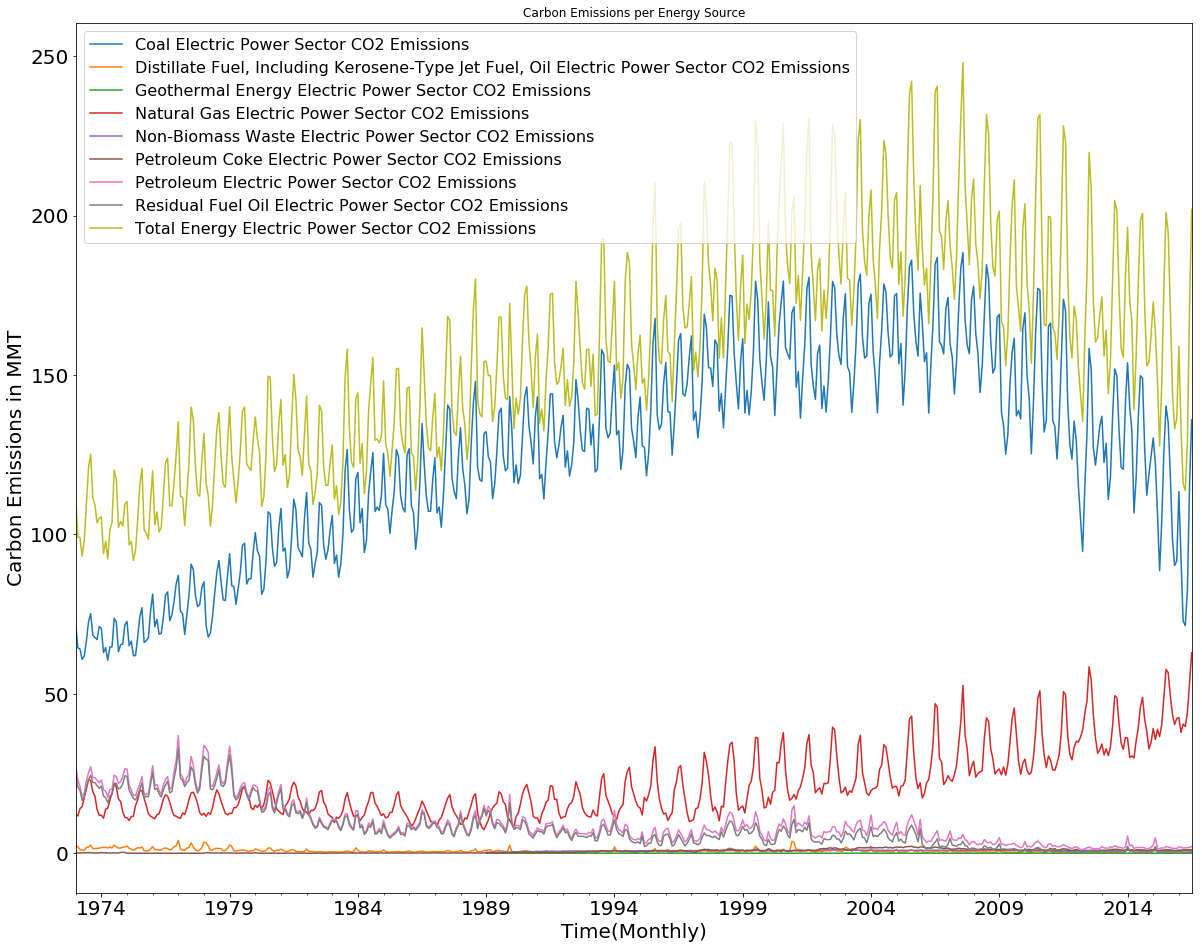

In [13]:
fig, ax = plt.subplots()
for desc, group in Energy_sources:
    group.plot(x = group.index, y='Value', label=desc,ax = ax, title='Carbon Emissions per Energy Source', fontsize = 20)
    ax.set_xlabel('Time(Monthly)')
    ax.set_ylabel('Carbon Emissions in MMT')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.legend(fontsize = 16)

Individually, we can visualize the trend and seasonality effect on CO2 emission from each energy source. For example, the CO2 emission from coal shows a trend of increment from 1973 to 2006 and then declines till 2016. 

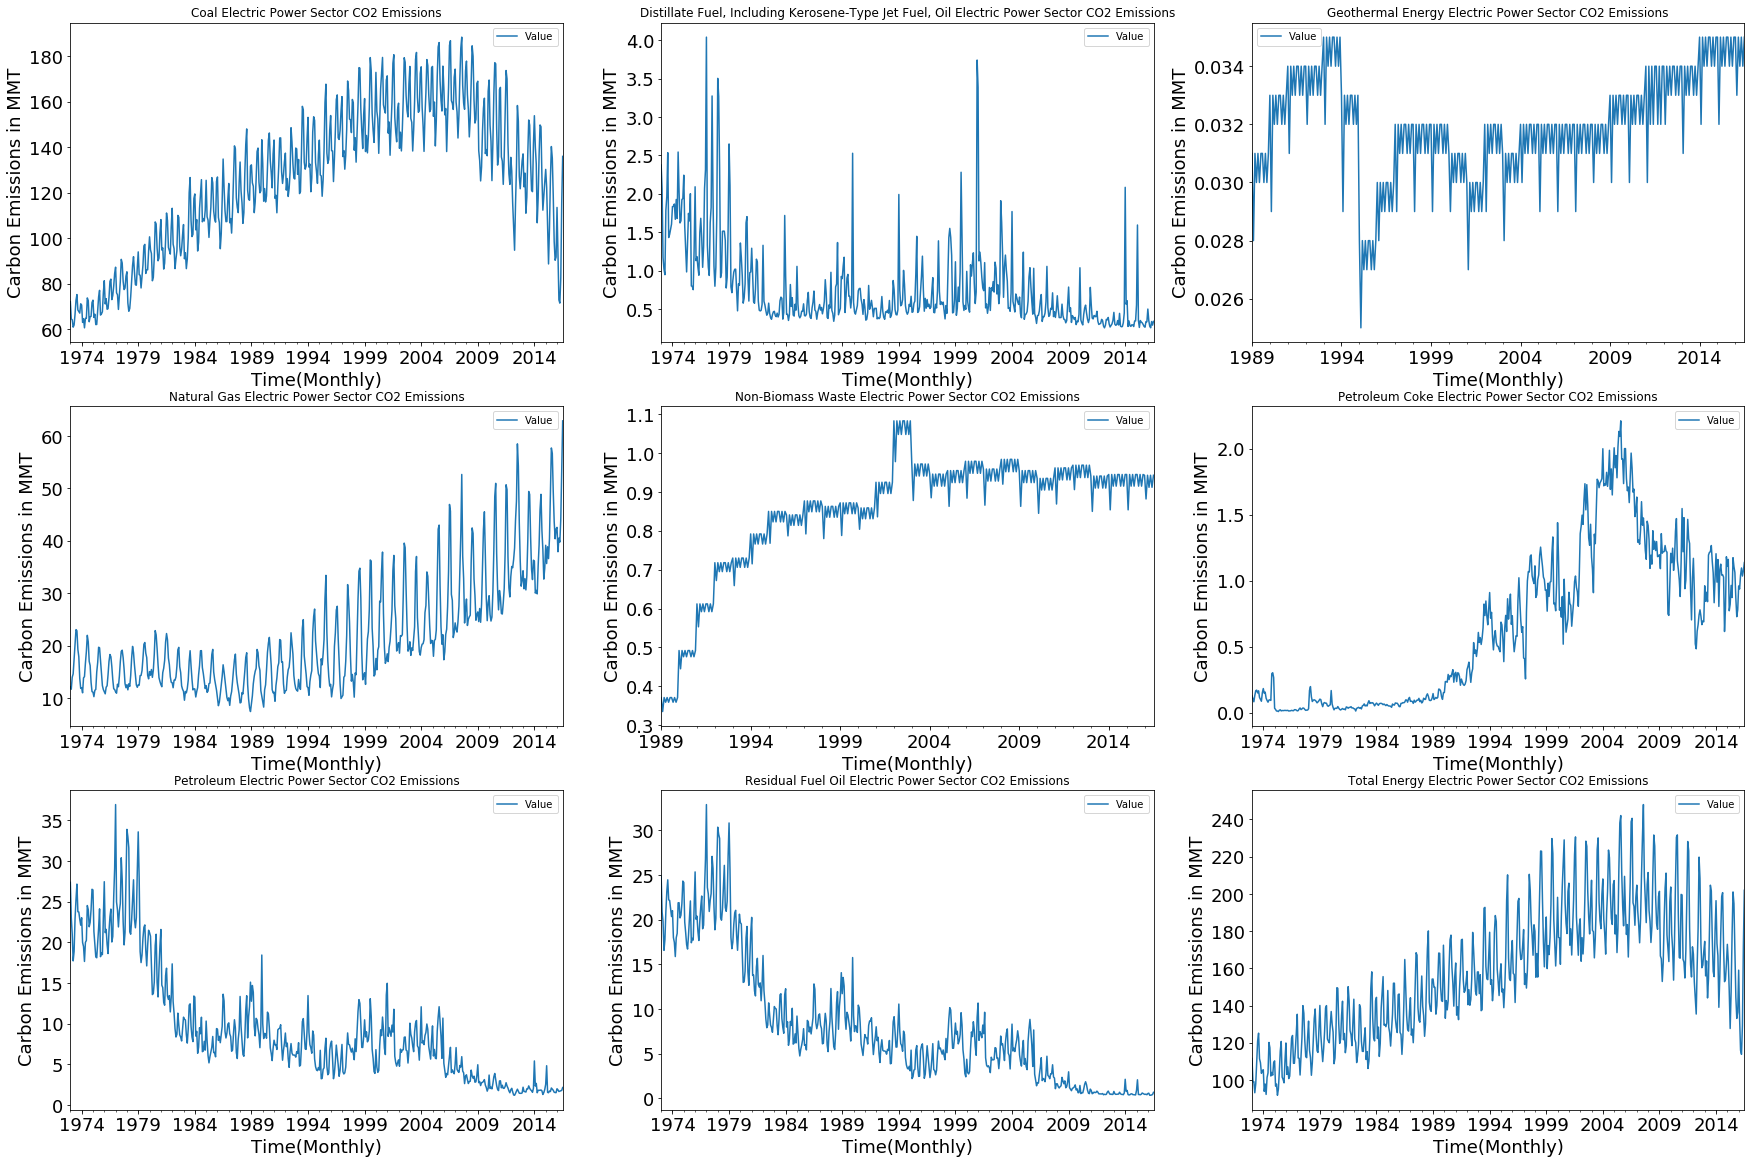

In [14]:
fig, axes = plt.subplots(3,3, figsize = (30, 20))
for (desc, group), ax in zip(Energy_sources, axes.flatten()):
    group.plot(x = group.index, y='Value',ax = ax, title=desc, fontsize = 18)
    ax.set_xlabel('Time(Monthly)')
    ax.set_ylabel('Carbon Emissions in MMT')
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

In recent years, the natural gas consumption has been increasing. However, the use of coal for power generation has been declining. The plots of CO2 emissions from coal and natural gas show this trend, while declining the CO2 contribution from coal, there is an increment in the contribution of CO2 emission from natural gas.

   ## 4.3	Bar chart of CO2 Emissions per energy source

In [15]:
CO2_per_source = ts.groupby('Description')['Value'].sum().sort_values()

In [16]:
# I want to use shorter descriptions for the energy sources
CO2_per_source.index

Index(['Geothermal Energy Electric Power Sector CO2 Emissions',
       'Non-Biomass Waste Electric Power Sector CO2 Emissions',
       'Petroleum Coke Electric Power Sector CO2 Emissions',
       'Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions',
       'Residual Fuel Oil Electric Power Sector CO2 Emissions',
       'Petroleum Electric Power Sector CO2 Emissions',
       'Natural Gas Electric Power Sector CO2 Emissions',
       'Coal Electric Power Sector CO2 Emissions',
       'Total Energy Electric Power Sector CO2 Emissions'],
      dtype='object', name='Description')

In [17]:
cols = ['Geothermal Energy', 'Non-Biomass Waste', 'Petroleum Coke','Distillate Fuel ',
        'Residual Fuel Oil', 'Petroleum', 'Natural Gas', 'Coal', 'Total Emissions']

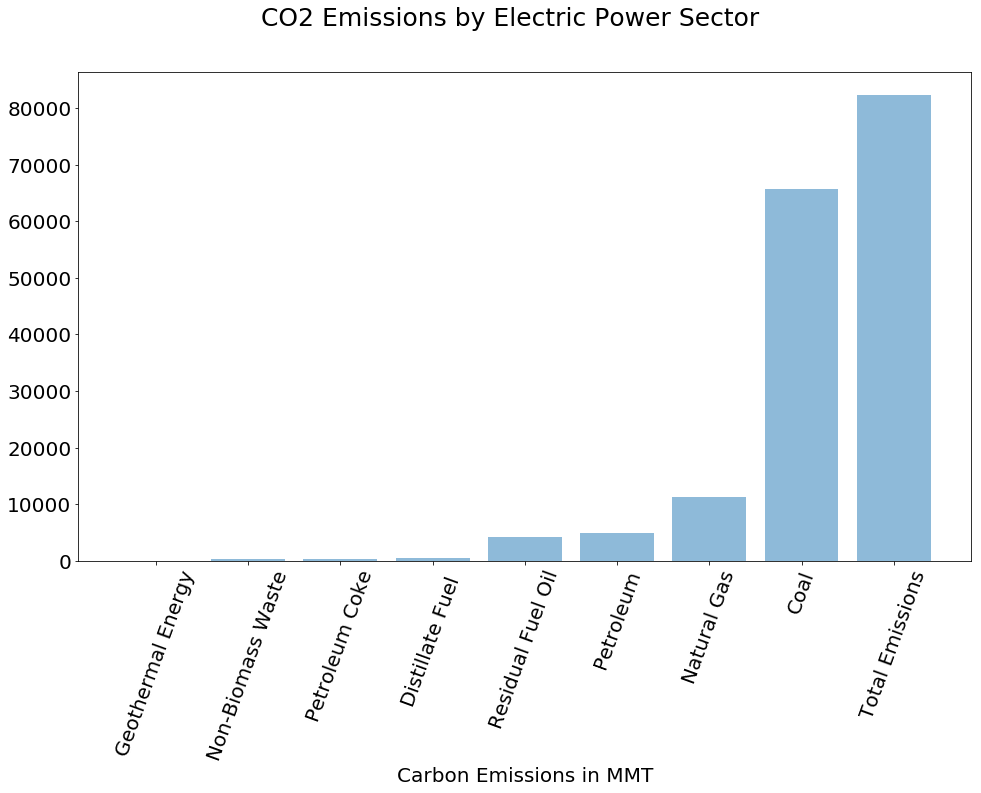

In [18]:
fig = plt.figure(figsize = (16,9))
x_label = cols
x_tick = np.arange(len(cols))
plt.bar(x_tick, CO2_per_source, align = 'center', alpha = 0.5)
fig.suptitle("CO2 Emissions by Electric Power Sector", fontsize= 25)
plt.xticks(x_tick, x_label, rotation = 70, fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Carbon Emissions in MMT', fontsize = 20)
plt.show()

**From the bar chart, we can see that the contribution of coal to the total CO2 emission is significant followed by natural gas. **

# 5) Natural gas CO2 emission analysis

For developing the time series model and make forcasting, I will use the natural gas CO2 emission from the electirical power generetion. First, let us slice this data from the ts as follows:  

In [19]:
Emissions = ts.iloc[:,1:]   # Monthly total emissions (mte)
Emissions= Emissions.groupby(['Description', pd.TimeGrouper('M')])['Value'].sum().unstack(level = 0)
mte = Emissions['Natural Gas Electric Power Sector CO2 Emissions'] # monthly total emissions (mte)
mte.head()

YYYYMM
1973-01-31    12.175
1973-02-28    11.708
1973-03-31    13.994
1973-04-30    14.627
1973-05-31    17.344
Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64

In [20]:
mte.tail()

YYYYMM
2016-03-31    40.525
2016-04-30    39.763
2016-05-31    44.210
2016-06-30    53.567
2016-07-31    62.881
Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64

## 5.1 Test Stationary

The first thing we need to do is producing a plot of our time series dataset. From the plot, we will get an idea about the overall trend and seasonality of the series. Then, we will use a statistical method to assess the trend and seasonality of the dataset.  After trend and seasonality are assessed if they are present in the dataset, they will be removed from the series to transform the nonstationary dataset into stationary and the residuals are further analyzed.
   
A short summary about stationarity from Wikipedia: A stationary process is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance, if they are present, also do not change over time. 

Stationarity is an assumption underlying many statistical procedures used in time series analysis, non-stationary data is often transformed to become stationary. The most common cause of violation of stationarity is a trend in the mean, which can be due to either the presence of a unit root or of a deterministic trend. If the nonstationarity is caused by the presence of unit root, stochastic shocks have permanent effects and the process is not mean-reverting. However, if it is caused by a deterministic trend, the process is called a trend stationary process, and stochastic shocks have only transitory effects after which the variable tends toward a deterministically evolving mean.
    
 A trend stationary process is not strictly stationary, but can easily be transformed into a stationary process by removing the underlying trend, which is solely a function of time. Similarly, processes with one or more unit roots can be made stationary through differencing. An important type of non-stationary process that does not include a trend-like behavior is a cyclostationary process, which is a stochastic process that varies cyclically with time.

Note: Given two jointly distributed random variables X and Y, the conditional probability distribution of Y given X is the probability distribution of Y when X is known to be a particular value.


In [21]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

## 5.1.1 Graphycally test stationary

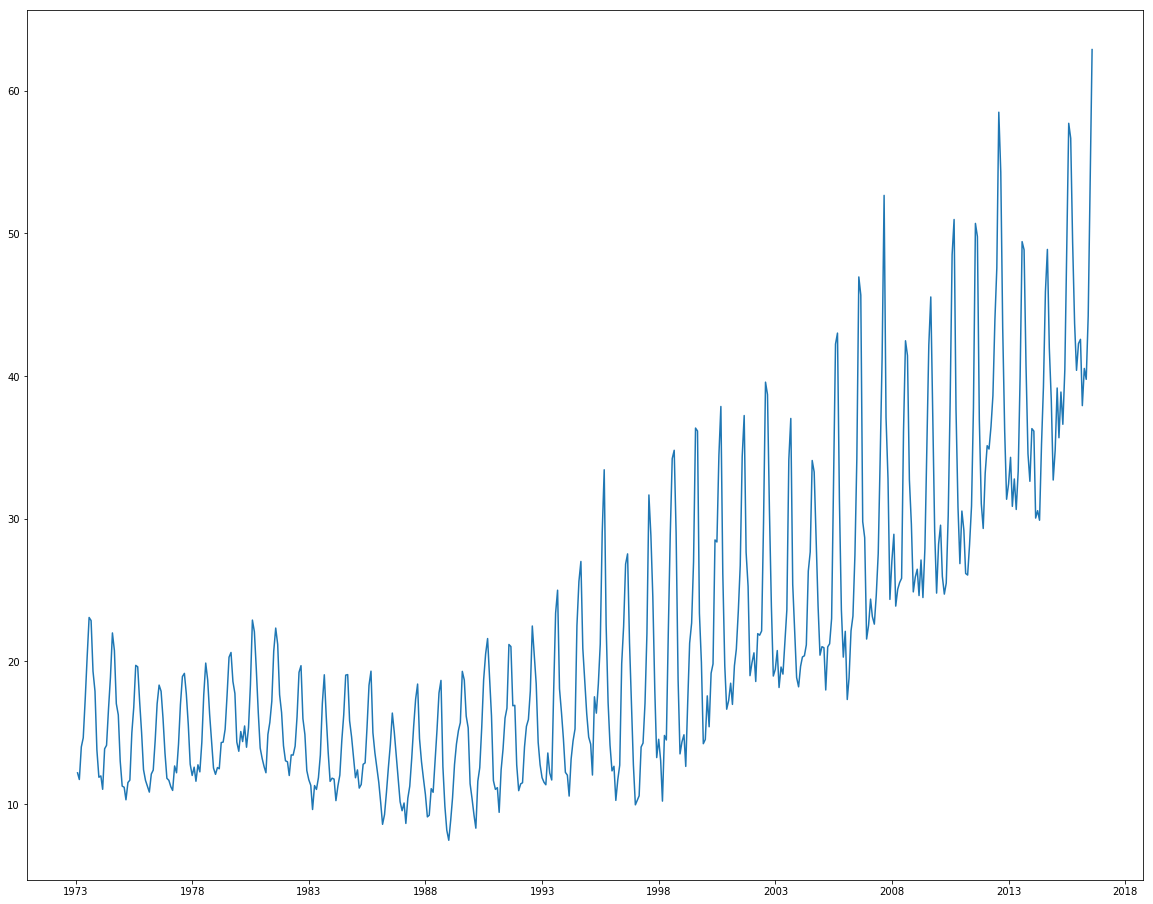

In [22]:
plt.plot(mte)

From the figures, it is evident that there is a trend in the CO2 emission dataset with seasonal variation. So, we can infer a concluding remark that the dataset is not stationary.

## 5.1.2 Test  stationary using Dickey-Fuller

A formal way of testing stationarity of a dataset is using plotting the moving average or moving variance and see if the series mean and variance varies with time. This approach will be handled by the TestStationaryPlot() method. The second way to test stationarity is to use the statistical test (the Dickey-Fuller Test). The null hypothesis for the test is that the time series is non-stationary. The test results compare a Test Statistic and Critical Values (cutoff value) at different confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. This technique will be handled by the TestStationaryAdfuller( ) method given below.


In [23]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    plt.xlabel('Time in Years', fontsize = 25)
    plt.ylabel('Total Emissions', fontsize = 25)
    plt.legend(loc='best', fontsize = 25)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)

In [24]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        

### Testing the monthly emissions time series

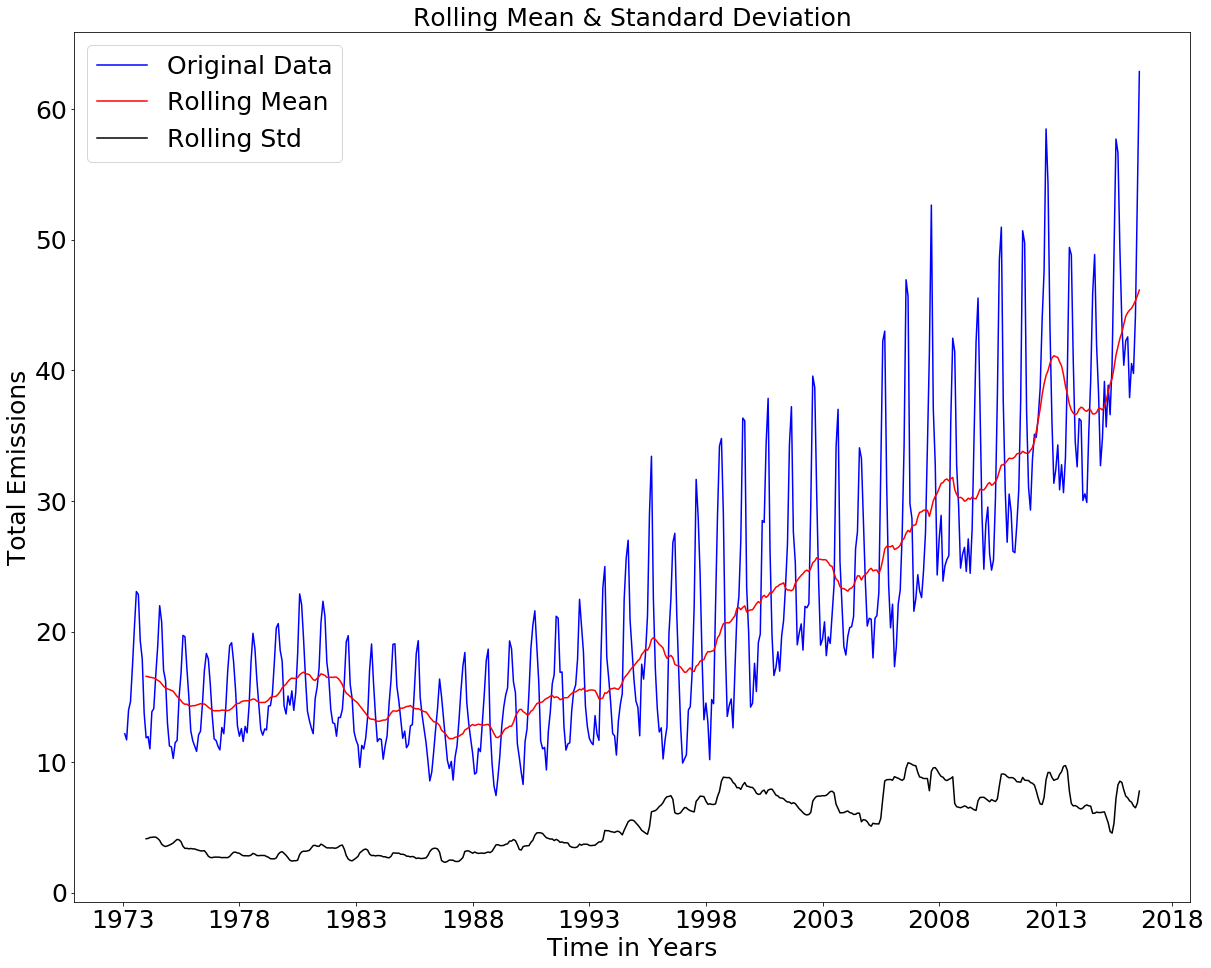

In [25]:
TestStationaryPlot(mte)

In [26]:
TestStationaryAdfuller(mte)

Test Statistic                   1.831215
p-value                          0.998409
#Lags Used                      19.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


The emissions mean and the variation in standard deviation (black line) clearly vary with time. This shows that the series has a trend. So, it is not a stationary. Also, the Test Statistic is greater than the critical values with 90%, 95% and 99% confidence levels. Hence, no evidence to reject the null hypothesis. Therefore the series is nonstationary. 

## 5.1.3 Transform the dataset to stationary

The most common techniques used to estimate or model trend and then remove it from the time series are 
- Aggregation – taking average for a time period like monthly/weekly average
- Smoothing – taking rolling averages
- Polynomial Fitting – fit a regression model

## A). Moving average

In this technique, we take average of ‘k’ consecutive values depending on the frequency of time series (in this case 12 monthes per year). Here, we will take the average over the past 1 year.

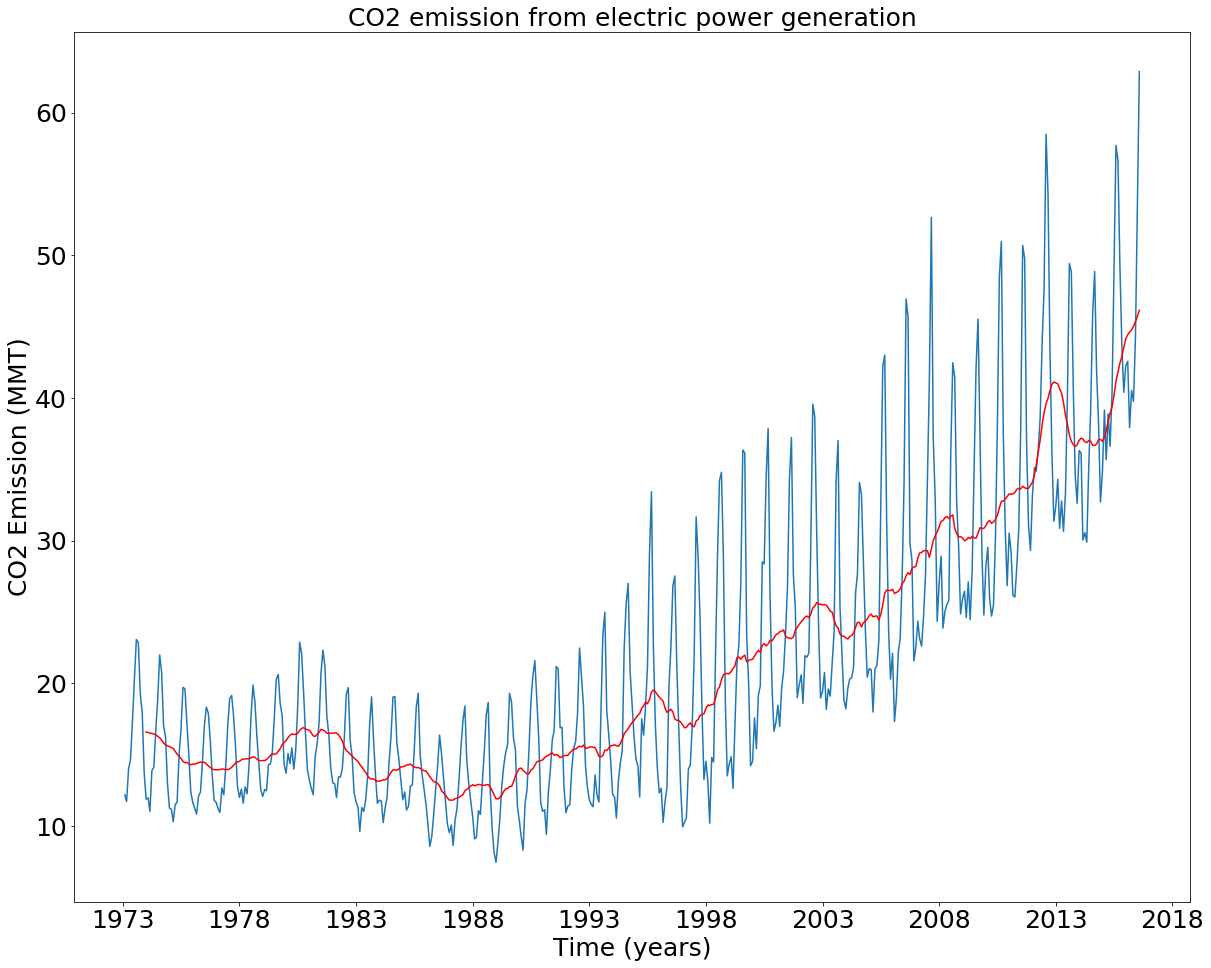

In [27]:
moving_avg = mte.rolling(12).mean()
plt.plot(mte)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Time (years)', fontsize = 25)
plt.ylabel('CO2 Emission (MMT)', fontsize = 25)
plt.title('CO2 emission from electric power generation', fontsize = 25)
plt.show()

The red line shows the rolling mean. Subtract the moving average from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. 

In [28]:
mte_moving_avg_diff = mte - moving_avg
mte_moving_avg_diff.head(13)

YYYYMM
1973-01-31         NaN
1973-02-28         NaN
1973-03-31         NaN
1973-04-30         NaN
1973-05-31         NaN
1973-06-30         NaN
1973-07-31         NaN
1973-08-31         NaN
1973-09-30         NaN
1973-10-31         NaN
1973-11-30         NaN
1973-12-31   -4.705333
1974-01-31   -4.594333
Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64

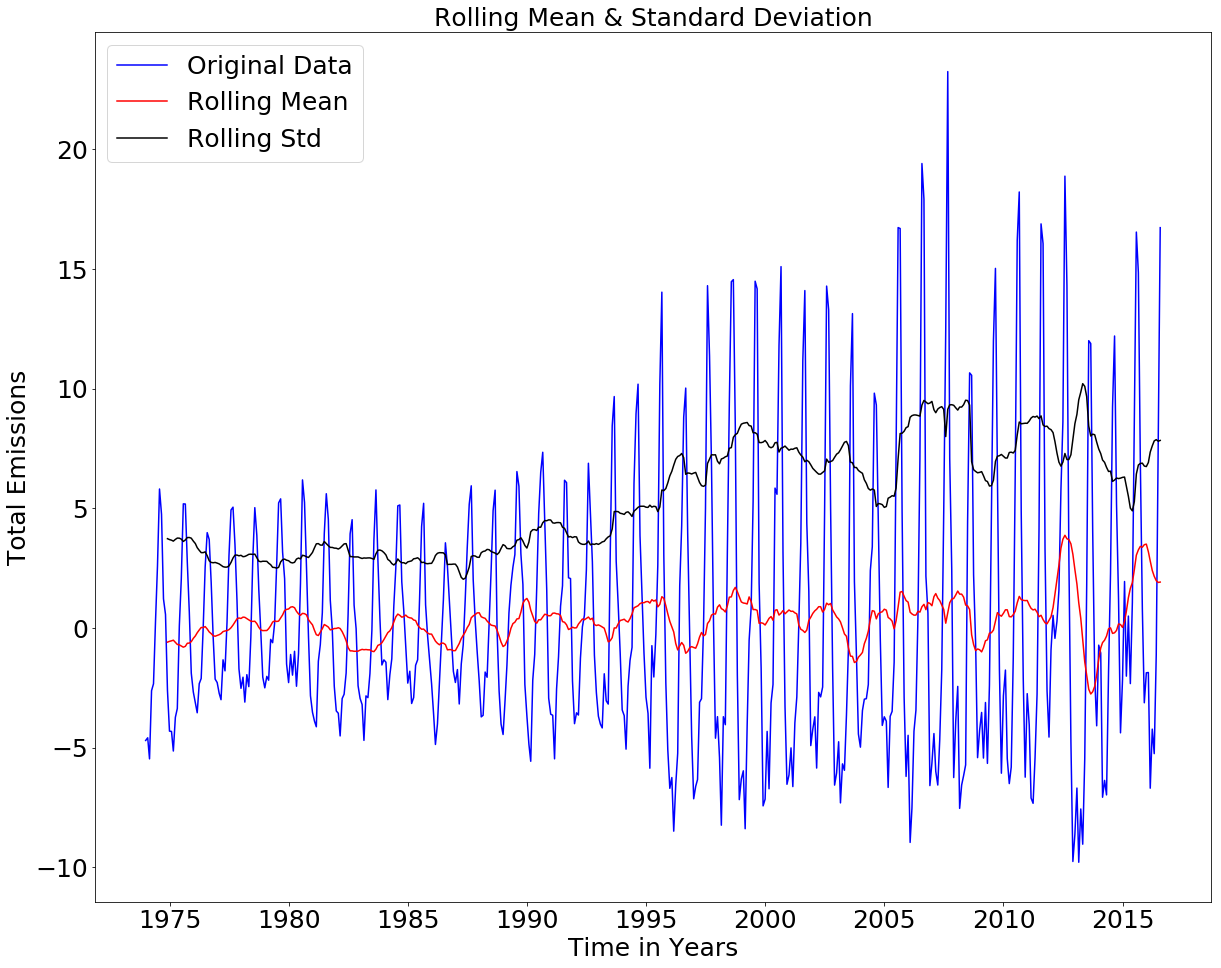

In [29]:
mte_moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(mte_moving_avg_diff)

In [30]:
TestStationaryAdfuller(mte_moving_avg_diff)

Test Statistic                  -5.138977
p-value                          0.000012
#Lags Used                      19.000000
Number of Observations Used    492.000000
Critical Value (1%)             -3.443711
Critical Value (5%)             -2.867432
Critical Value (10%)            -2.569908
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


The rolling mean values appear to be varying slightly. The Test Statistic is smaller than the 10% 5%, and 1% of critical values. So, we can say with 99% confidence level that the dataset is a stationary series.

## B). Exponentail weighted moving average

Another technique is to take the ‘weighted moving average’ where more recent values are given a higher weight. The popular method to assign the waights is using the exponential weighted moving average. Where weights are assigned to all previous values with a decay factor.

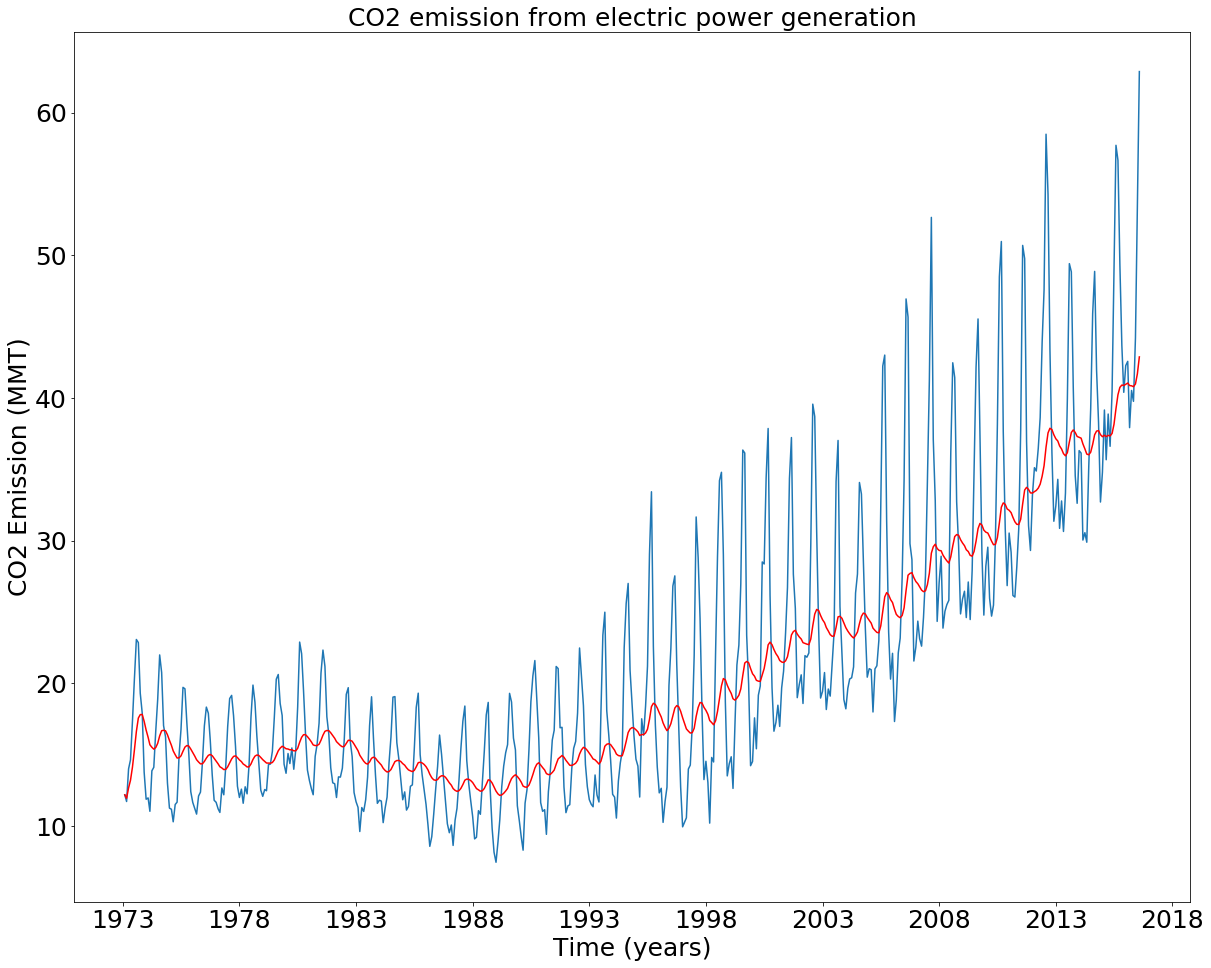

In [31]:
mte_exp_wighted_avg = pd.ewma(mte, halflife=12)
plt.plot(mte)
plt.plot(mte_exp_wighted_avg, color='red')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Time (years)', fontsize = 25)
plt.ylabel('CO2 Emission (MMT)', fontsize = 25)
plt.title('CO2 emission from electric power generation', fontsize = 25)
plt.show()

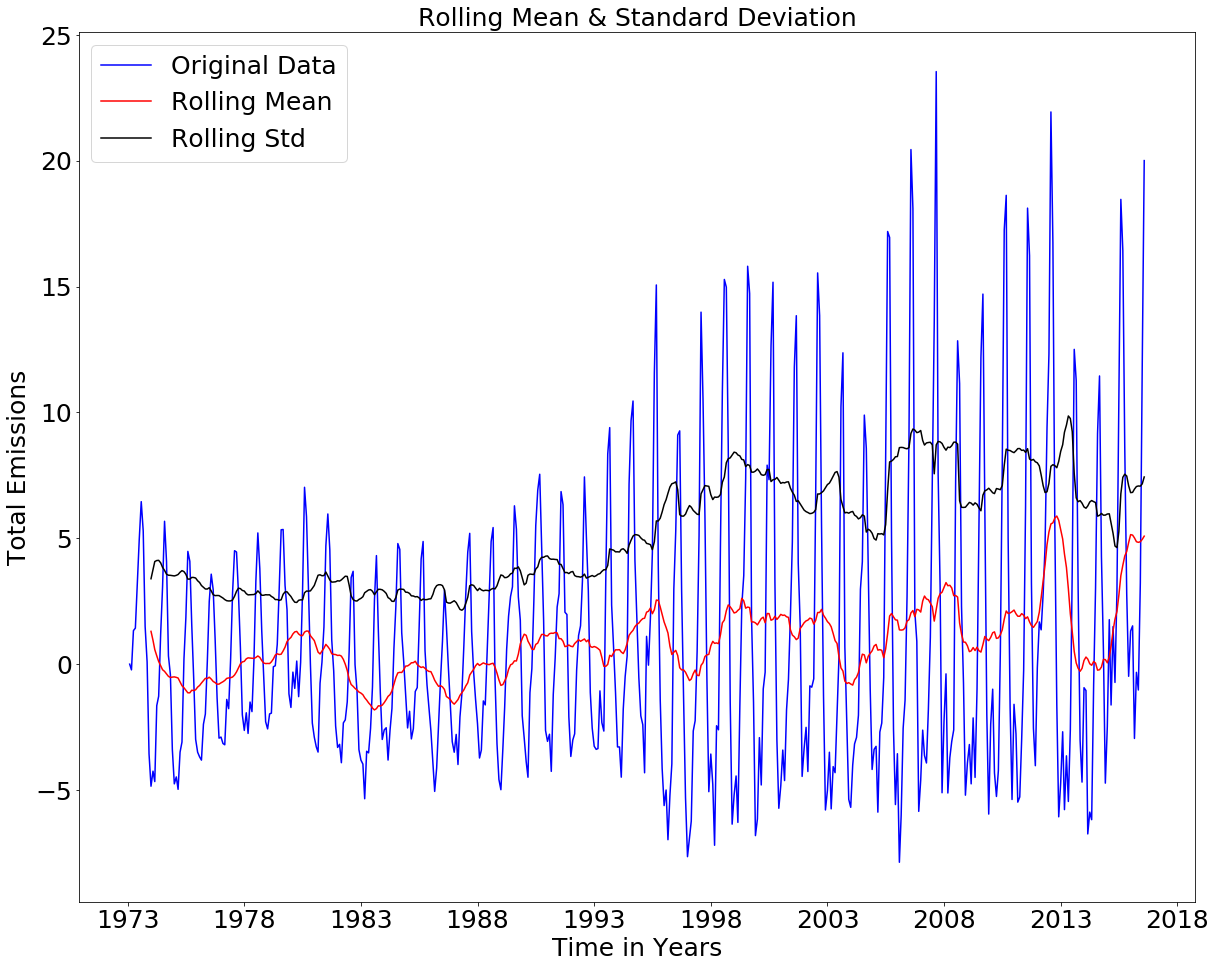

In [32]:
mte_ewma_diff = mte - mte_exp_wighted_avg
TestStationaryPlot(mte_ewma_diff)

In [33]:
TestStationaryAdfuller(mte_ewma_diff)

Test Statistic                  -3.423915
p-value                          0.010170
#Lags Used                      19.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


This time series has lesser variations in mean and standard deviation compared to the orginal ddataset. Also, the Test Statistic is smaller than the 5% and 10% critical value, which is better than the original case. There will be no missing values as all values from starting are given weights. So, it will work even with no previous values. In this case, we can say with 95% confidence level the series is a stationary series.

## C) Eliminating trend and seasonality: Differencing

One of the most common method of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the original observation at a particular instant with that at the previous instant. This mostly works well to improve stationarity. First order differencing can be done as follows:

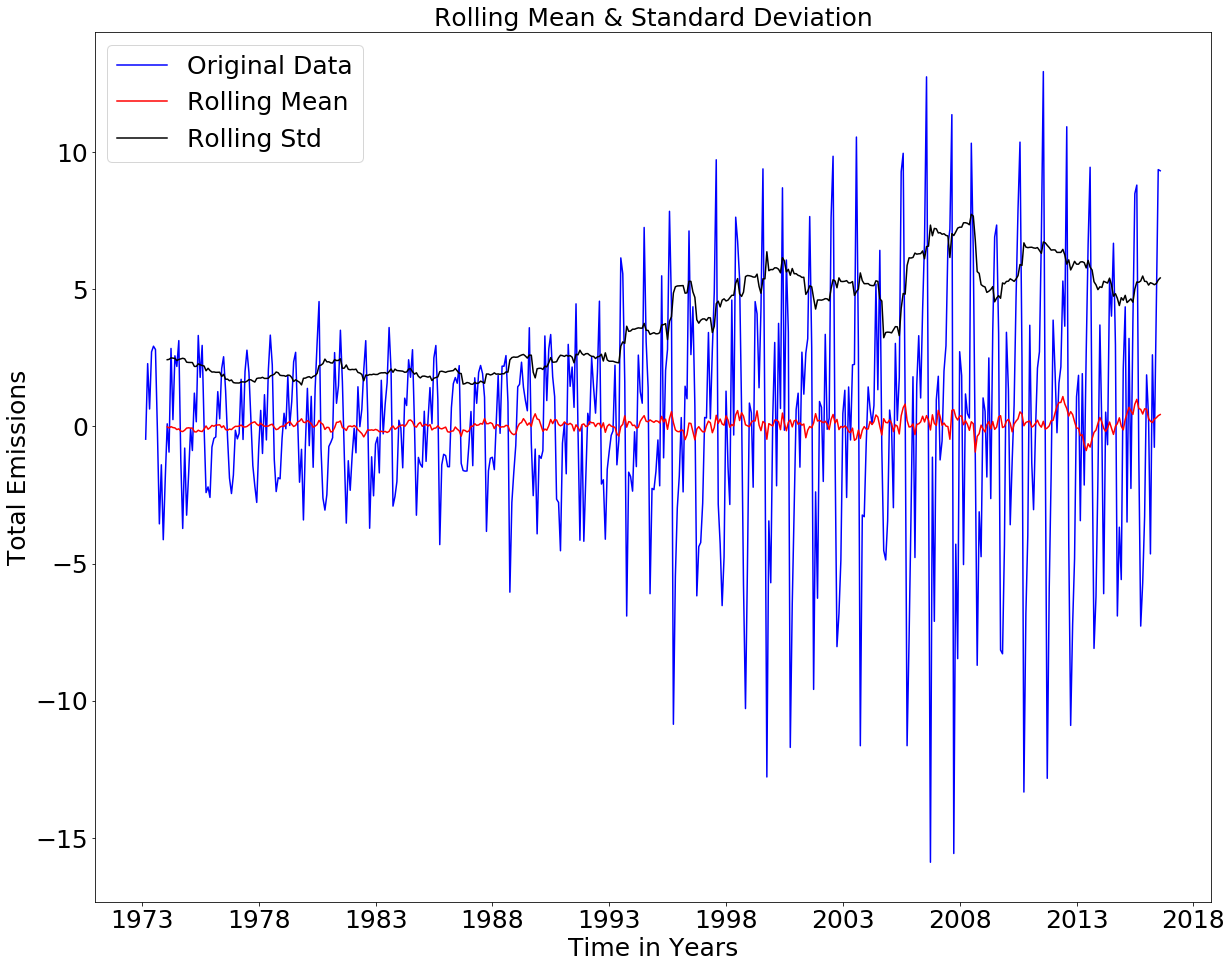

In [34]:
mte_first_difference = mte - mte.shift(1)  
TestStationaryPlot(mte_first_difference.dropna(inplace=False))

In [35]:
TestStationaryAdfuller(mte_first_difference.dropna(inplace=False))

Test Statistic                  -5.435116
p-value                          0.000003
#Lags Used                      18.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


The first difference improves the stationarity of the series significantly. Let us use also the ***seasonal difference*** to remove the seasonality of the data and see how that impacts stationarity of the data.

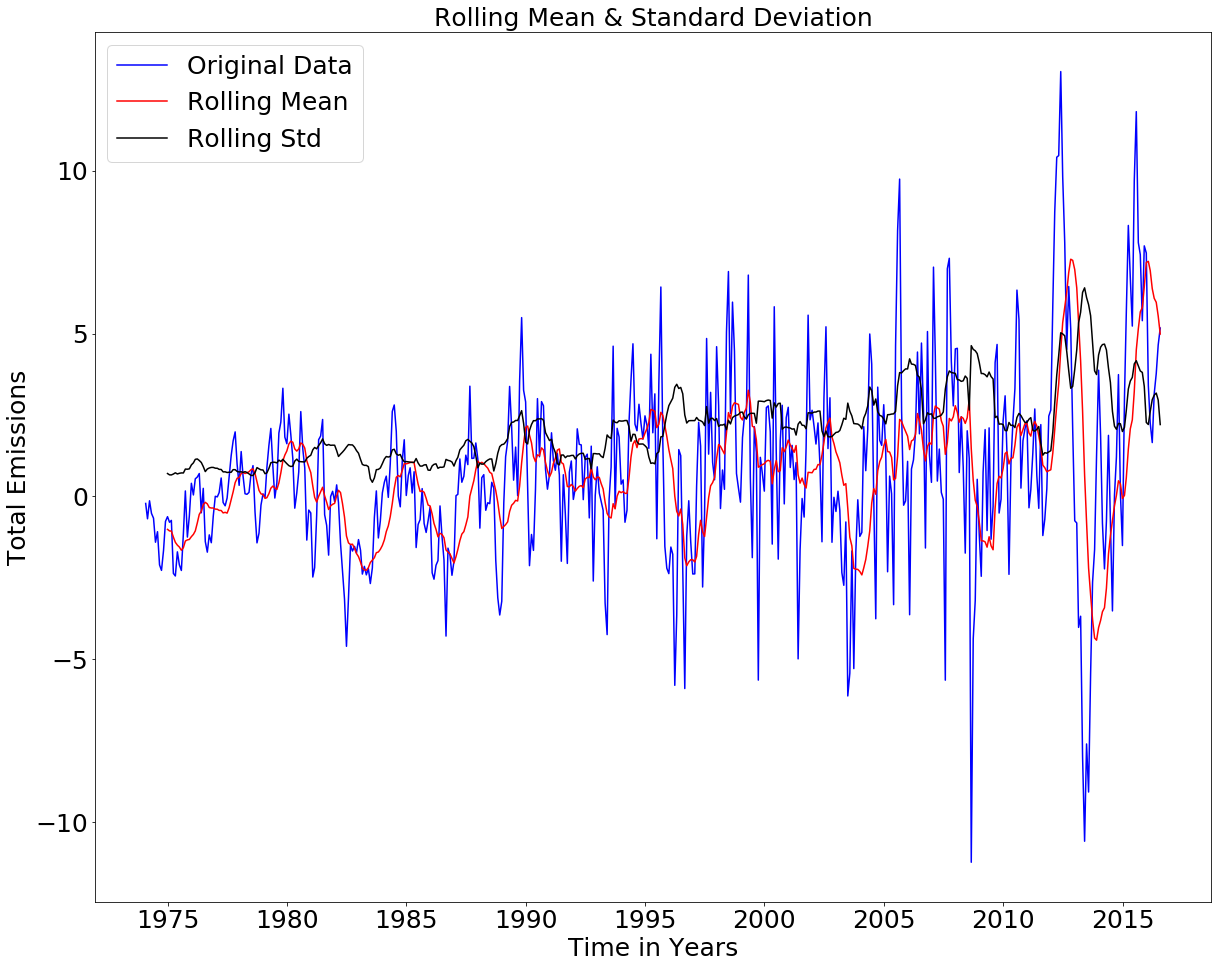

Test Statistic                  -4.412396
p-value                          0.000282
#Lags Used                      13.000000
Number of Observations Used    497.000000
Critical Value (1%)             -3.443576
Critical Value (5%)             -2.867373
Critical Value (10%)            -2.569877
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [36]:
mte_seasonal_difference = mte - mte.shift(12)  
TestStationaryPlot(mte_seasonal_difference.dropna(inplace=False))
TestStationaryAdfuller(mte_seasonal_difference.dropna(inplace=False))

Compared to the original data the seasonal difference also improves the stationarity of the series. The next step is to take the first difference of the seasonal difference.

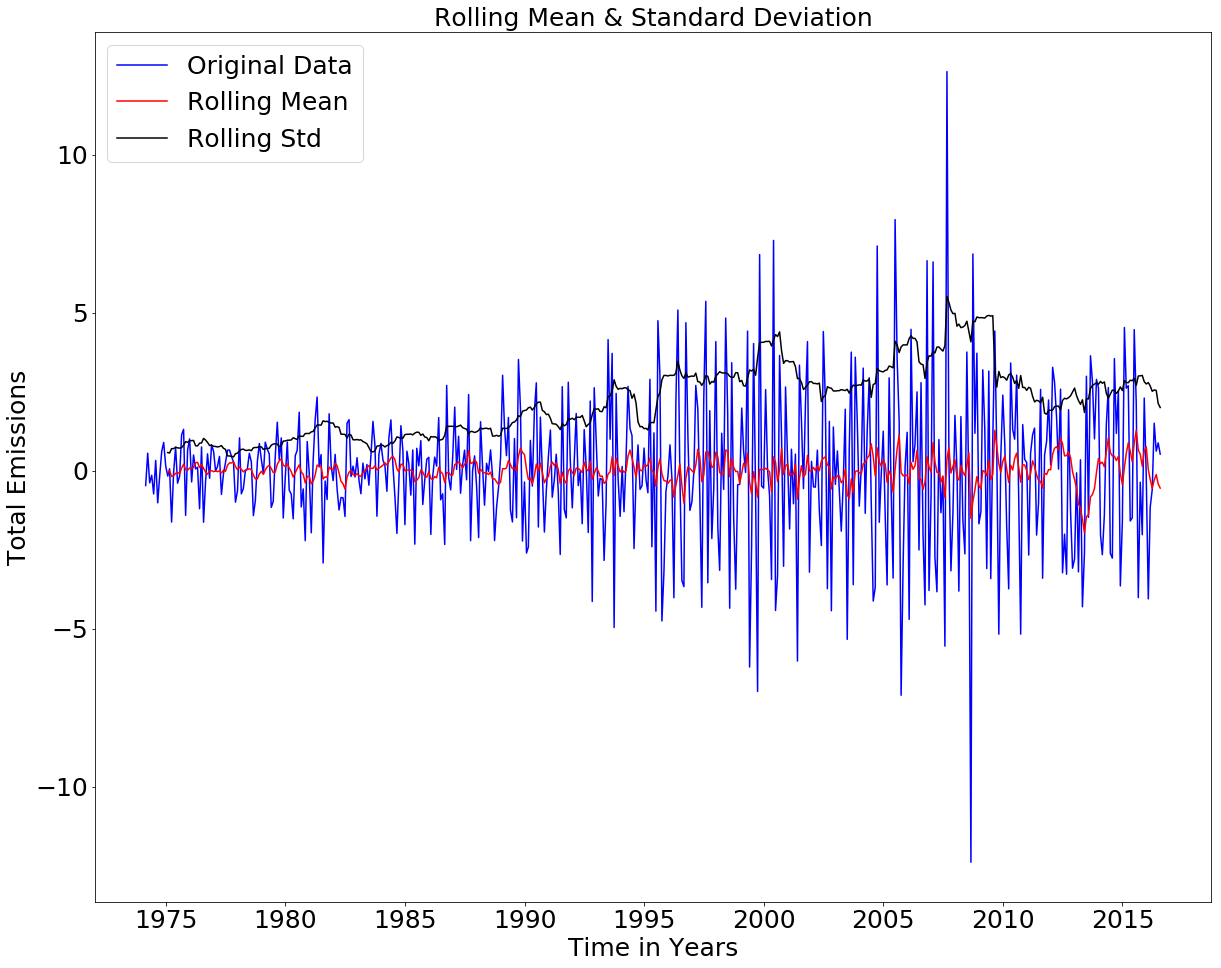

In [37]:
mte_seasonal_first_difference = mte_first_difference - mte_first_difference.shift(12)  
TestStationaryPlot(mte_seasonal_first_difference.dropna(inplace=False))

In [38]:
TestStationaryAdfuller(mte_seasonal_first_difference.dropna(inplace=False))

Test Statistic                -1.009743e+01
p-value                        1.081539e-17
#Lags Used                     1.200000e+01
Number of Observations Used    4.970000e+02
Critical Value (1%)           -3.443576e+00
Critical Value (5%)           -2.867373e+00
Critical Value (10%)          -2.569877e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


Now, if we look the Test Statistic and the p-value, taking the seasonal first difference has made our the time series dataset stationary. This differencing procedure could be repeated for the log values, but it didn’t make the dataset any more stationary.

## D) Eliminating trend and seasonality: Decomposing

In this technique, it statrating by modeling both trend and seasonality and removing them from the model.

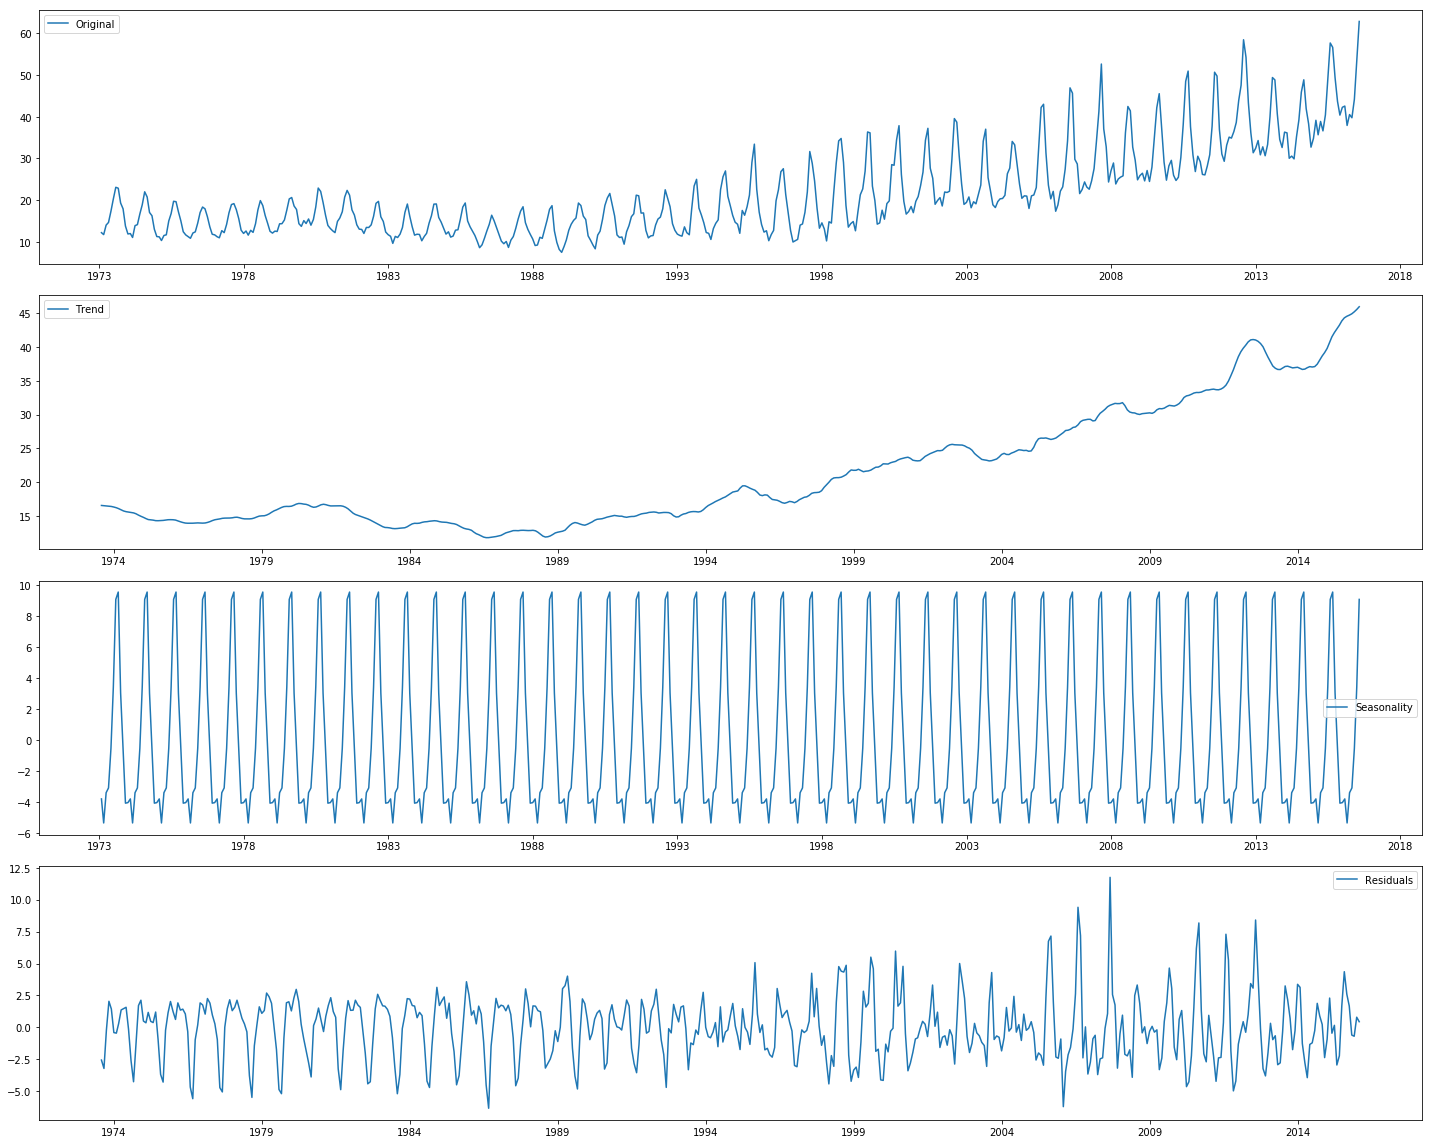

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(mte)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(mte, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

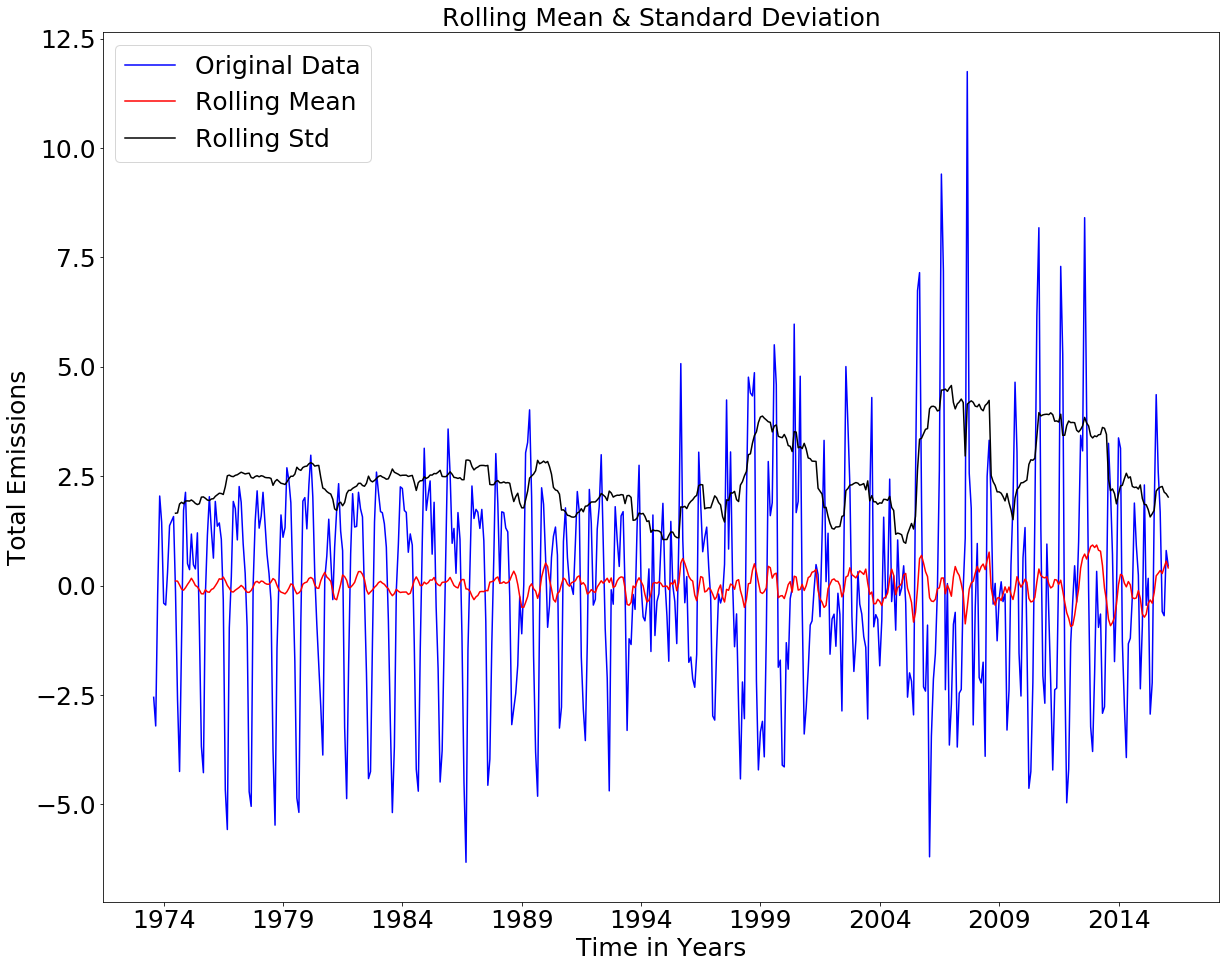

Test Statistic                -8.547084e+00
p-value                        9.439345e-14
#Lags Used                     1.900000e+01
Number of Observations Used    4.910000e+02
Critical Value (1%)           -3.443739e+00
Critical Value (5%)           -2.867444e+00
Critical Value (10%)          -2.569915e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [40]:
mte_decompose = residual
mte_decompose.dropna(inplace=True)
TestStationaryPlot(mte_decompose)
TestStationaryAdfuller(mte_decompose)

# 6) Find optimal parameters and build SARIMA model

When looking to fit time series dataset with seasonal ARIMA model, our first goal is to find the values of SARIMA(p,d,q)(P,D,Q)s that optimize our metric of interest. Before moving directly how to find the optimal values of the parameters let us see the two situations in stationarities: A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as **white noise.** The second case being a series with significant dependence among values and needs statistical models like ARIMA to forecast future oucomes.

**Auto-Regressive Integrated Moving Average (ARIMA)**: The ARIMA forecasting for a stationary time series is a linear funcion similar to linear regression. The predictors mainly depend on the parameters (p,d,q) of the ARIMA model:

* Number of **Auto-Regressive (AR) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 4, the predictors for x(t) will depend on x(t-1)….x(t-4).  This term allows us to incorporate the effect of past values into our model. This would be similar to stating that the weather is likely to be warm tomorrow if it has been warm the past 4 days.
* Number of **Moving Average(MA) terms (q)**: MA terms are lagged forecast errors in prediction function. This term allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past. For instance if q is 4, the predictors for x(t) will be e(t-1)….e(t-4) where e(i) is the difference between the moving average at ith instant and actual value.
* Number of** Differences (d)**: These are the number of nonseasonal differences, i.e.,  if we took the first order difference. So either we can pass the first order difference variable and put d=0 or pass the original observed variable and put d=1. Both will generate same results. This term explains the number of past time points to subtract from the current value. This would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

# 6.1 Plot the ACF and PACF charts and find the optimal parameters

* **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the time series (ts) with a lagged version of itself. For instance at lag 4, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-4’…’t2-4’ (t1-4 and t2 being end points of the range).
* **Partial Autocorrelation Function (PACF)**: This measures the correlation between the ts with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 4, it will check the correlation but remove the effects already explained by lags 1 to  3.

Therefore, the next step will be determing the tuning parameters (p and q) of the model by looking at the autocorrelation and partial autocorrelation graphs.  The chart below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs inorder to select the parameters. 

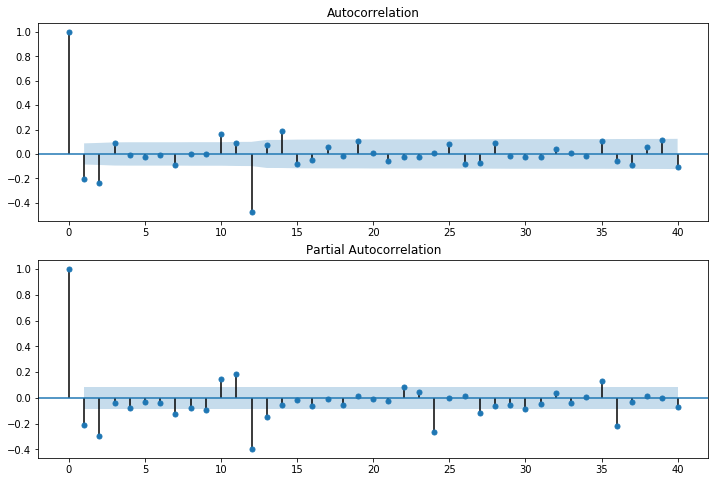

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

# 6.2 Grid search 

To find the optimal parameters for ARIMA models using the graphical method is not trivial and it is time consuming. We will select the optimal parameter values systematically using the grid search (hyperparameter optimization) method. The grid search iteratively explore different combinations of the parameters. For each combination of parameters, we will fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let's begin by generating the various combination of parameters that we wish to assess:

In [42]:
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)



When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. The lowest AIC  refore, we are interested in finding the model that yields the lowest AIC value.

The order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [43]:
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(mte,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


SARIMAX(1, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 2003.553. Therefore, we will consider this to be optimal option out of all the parameter combinations.W e have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

In [44]:
mod = sm.tsa.statespace.SARIMAX(mte, 
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                          Statespace Model Results                                         
Dep. Variable:     Natural Gas Electric Power Sector CO2 Emissions   No. Observations:                  523
Model:                              SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -997.777
Date:                                             Fri, 12 Jan 2018   AIC                           2003.553
Time:                                                     04:47:15   BIC                           2020.592
Sample:                                                 01-31-1973   HQIC                          2010.226
                                                      - 07-31-2016                                         
Covariance Type:                                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value close to 0, so it is reasonable to include the features in our model.

When fitting seasonal ARIMA models, it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

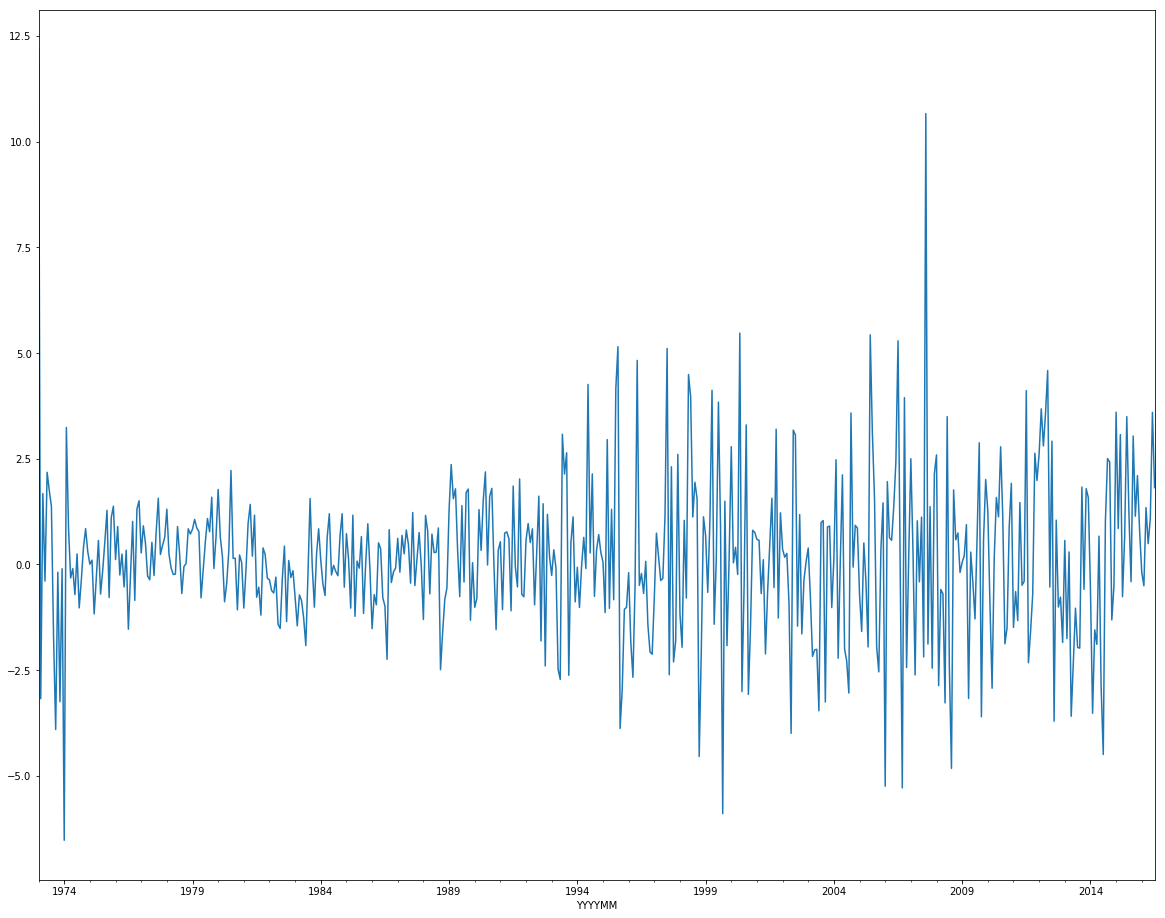

In [45]:
results.resid.plot()

In [46]:
print(results.resid.describe())

count    523.000000
mean       0.144267
std        1.885626
min       -6.528425
25%       -0.791260
50%        0.126975
75%        1.040651
max       12.175000
dtype: float64


The figure displays the distribution of the residual errors. It shows a little bias in the prediction. Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

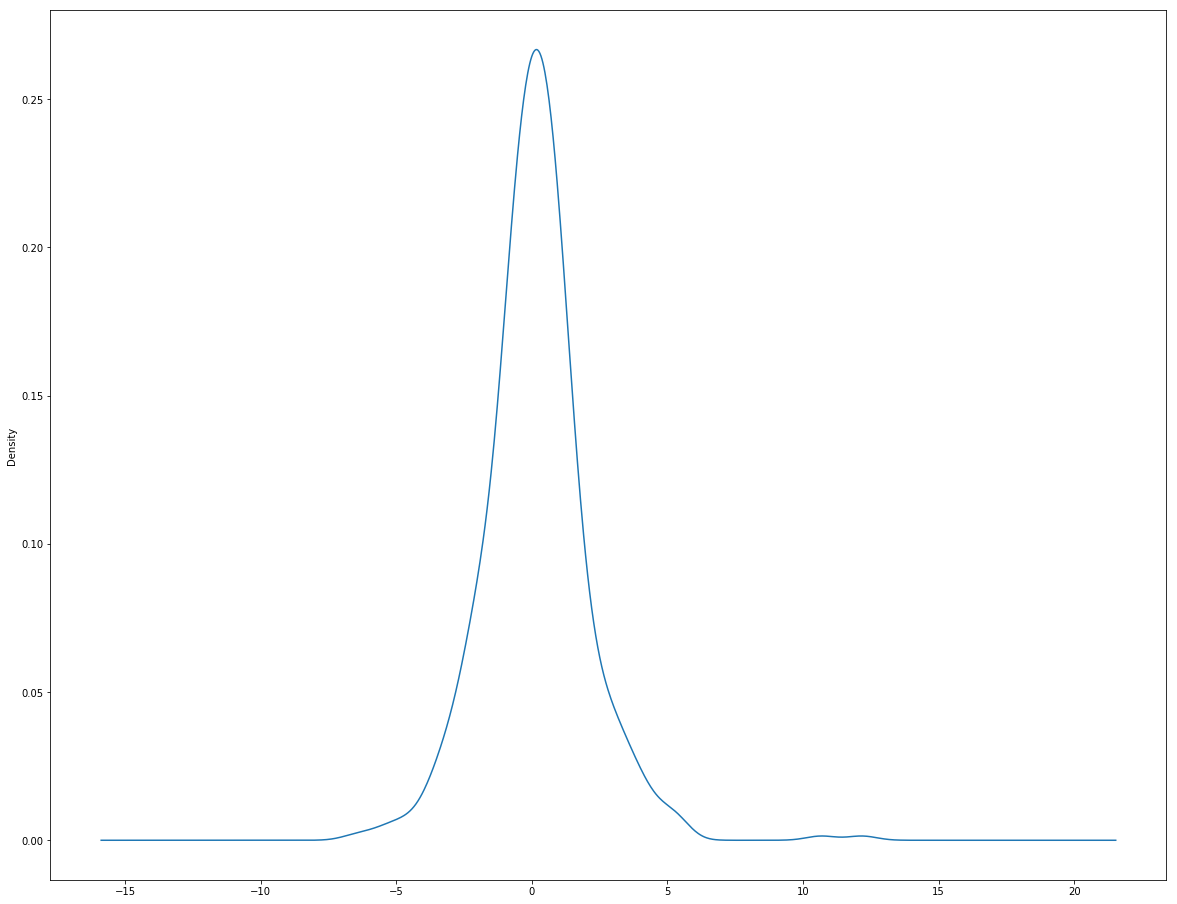

In [47]:
results.resid.plot(kind='kde')

The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

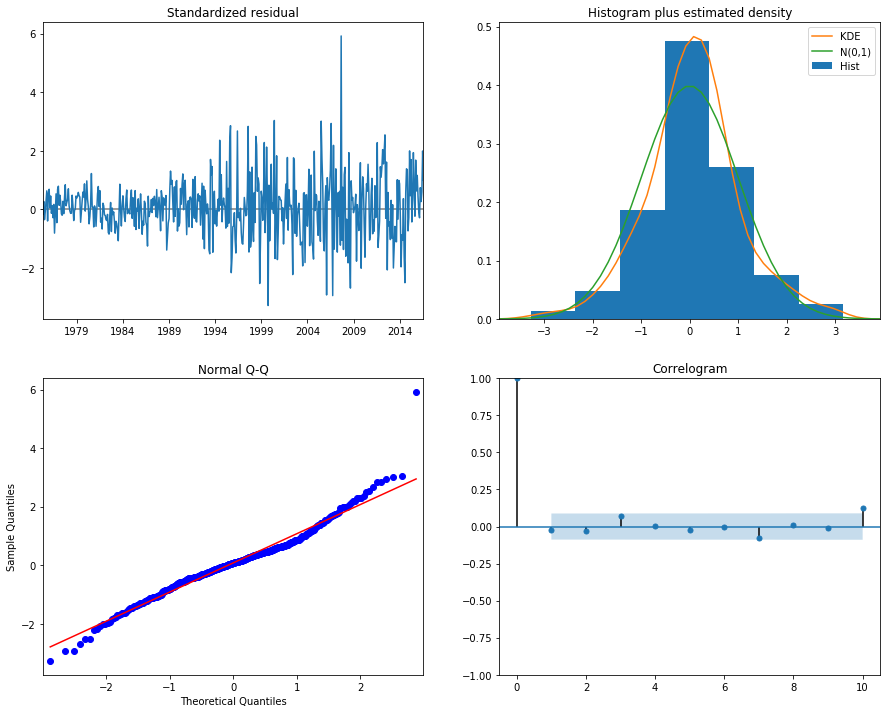

In [48]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

The model diagnostic suggests that the model residual is normally distributed based on the following:

- In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed. The forecast errors deviate somewhat from the straight line, indicating that the normal distribution is not a perfect model for the distribution of forecast errors, but it is not unreasonable.
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

# 7) Validating prediction

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecast. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [49]:
pred = results.get_prediction(start = 480, end = 523, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

lower Natural Gas Electric Power Sector CO2 Emissions  \
2013-01-31                                          30.203834       
2013-02-28                                          29.088380       
2013-03-31                                          28.958984       
2013-04-30                                          30.708073       
2013-05-31                                          32.104079       

            upper Natural Gas Electric Power Sector CO2 Emissions  
2013-01-31                                          37.257324      
2013-02-28                                          36.141870      
2013-03-31                                          36.012474      
2013-04-30                                          37.761563      
2013-05-31                                          39.157569

The dynamic=False argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

We can plot the real and forecasted values of the CO2 emission time series to assess how well the model fits.

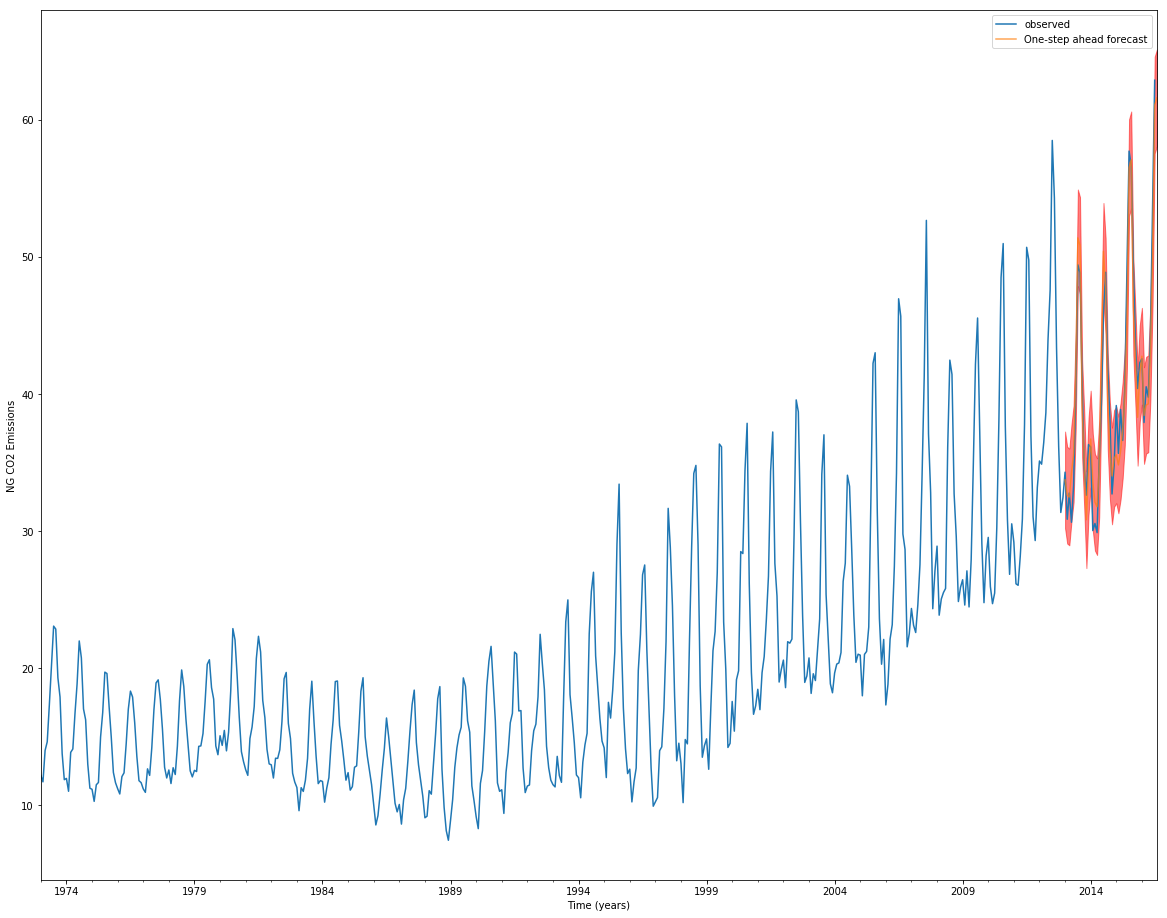

In [50]:
ax = mte['1973':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('NG CO2 Emissions')
plt.legend()

plt.show()

Overall, our forecasts align with the true values very well, showing an overall similar behavior.

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out.

In [51]:
mte_forecast = pred.predicted_mean
mte_truth = mte['2013-01-31':]

# Compute the mean square error
mse = ((mte_forecast - mte_truth) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((mte_forecast-mte_truth)**2)/len(mte_forecast))))

The Mean Squared Error (MSE) of the forecast is 4.09
The Root Mean Square Error (RMSE) of the forcast: nan


In [52]:
mte_pred_concat = pd.concat([mte_truth, mte_forecast])

The goal of developing the model is to get a good quality predictive power using dynamic forecast. That is, we use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points as follows:

In [53]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2013-01-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

From, plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when we use the dynamic forecast. All forecasted values (red line) match closely to the orginal observed (blue line) data, and are well within the confidence intervals of our forecast.

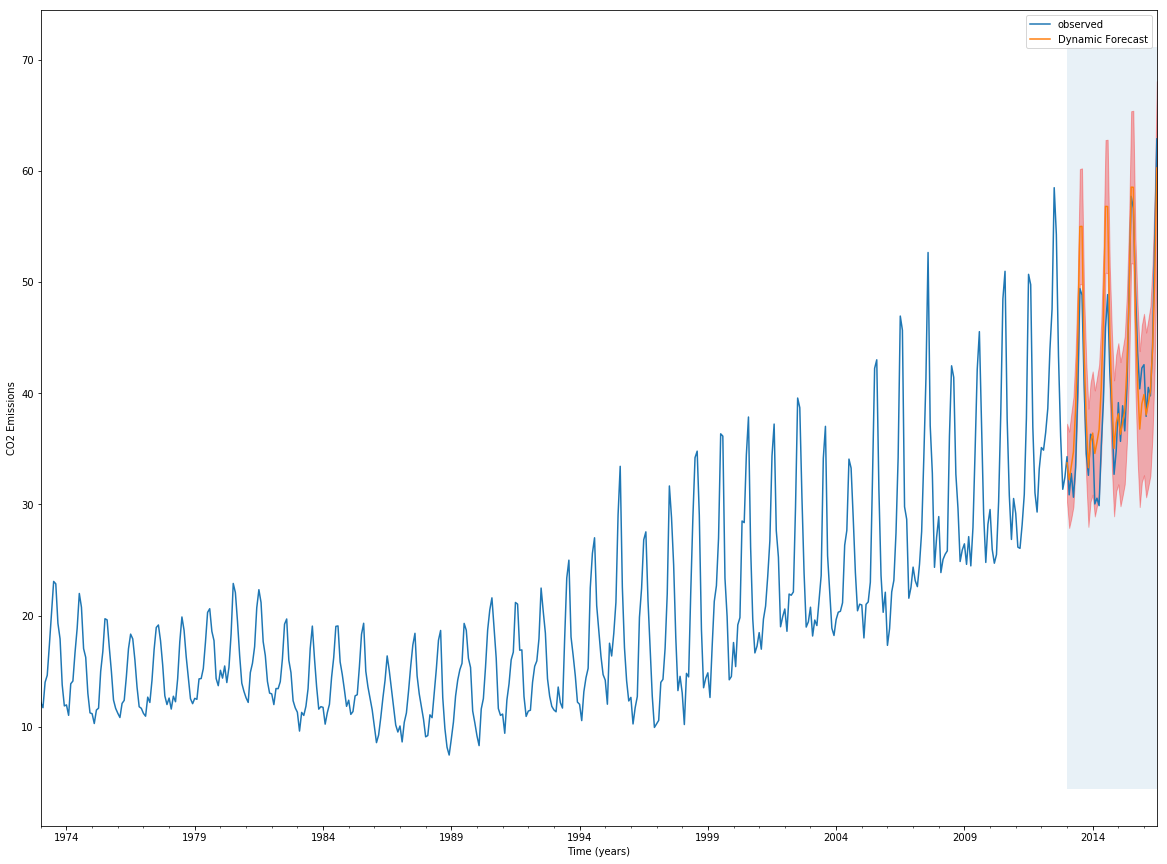

In [54]:
ax = mte['1973':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], 
                color='r', 
                alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-01-31'), 
                 mte.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('CO2 Emissions')

plt.legend()
plt.show()

In [55]:
# Extract the predicted and true values of our time series
mte_forecast = pred_dynamic.predicted_mean
mte_orginal = mte['2013-01-31':]

# Compute the mean square error
mse = ((mte_forecast - mte_orginal) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((mte_forecast-mte_orginal)**2)/len(mte_forecast))))

The Mean Squared Error (MSE) of the forecast is 14.39
The Root Mean Square Error (RMSE) of the forcast: 3.7936


# 8) Forecasting

In [56]:
# Get forecast of 10 years or 120 months steps ahead in future
forecast = results.get_forecast(steps= 120)
# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.head()

lower Natural Gas Electric Power Sector CO2 Emissions  \
2016-08-31                                          58.062559       
2016-09-30                                          47.316614       
2016-10-31                                          40.736071       
2016-11-30                                          36.175922       
2016-12-31                                          38.095110       

            upper Natural Gas Electric Power Sector CO2 Emissions  
2016-08-31                                          65.116049      
2016-09-30                                          55.987495      
2016-10-31                                          50.163095      
2016-11-30                                          46.010287      
2016-12-31                                          48.172698

We can use the output of this code to plot the time series and forecasts of its future values.

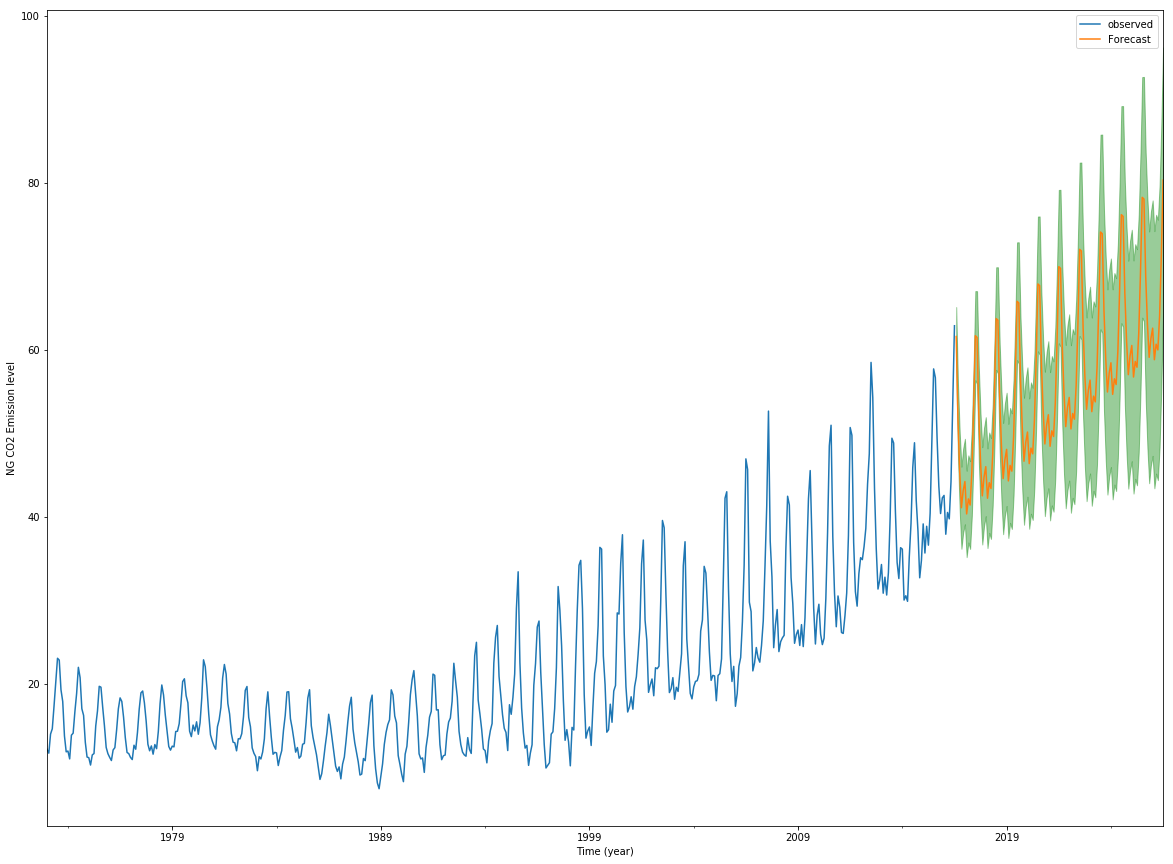

In [57]:
ax = mte.plot(label='observed', figsize=(20, 15))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.4)
ax.set_xlabel('Time (year)')
ax.set_ylabel('NG CO2 Emission level')

plt.legend()
plt.show()

Both the forecast and associated confidence interval that we have generated can now be used to further explore and understand the time series. The forecast shows that the CO2 emission from natural gas power generation is expected to continue increasing.

# 9) Conclusion

In this notebook, I have explored how to retrieve CSV dataset, how to transform the dataset into times series, testing if the time series is stationary or not using graphical and Dickey-Fuller test statistic methods, how to transform time series to stationary, how to find optimal parameters to build SARIMA model using grid search method, diagnosing time series prediction, validating the predictive power, forecasting 10 year future CO2 emission from power generation using natural gas.

Future work: developing a time series model of natural gas forecasing


Suggestion, comments and questions are welcome! 